# Summary of Imaging Analyses Results

In [424]:
# imports
import os
import polars as pl
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
import operator
from adjustText import adjust_text
import py3Dmol
import polars as pl
from Bio.PDB import PDBParser
from sklearn.cluster import AgglomerativeClustering
import sys
import glob

sns.set_style(style='white')
sys.path.append("../../..")
from utils import *

In [347]:
METADATA_INPUT = "../../../../1_allele_collection/1_inputs"
FEAT_SETS = ["GFP", "DNA", "Mito", "AGP", "Morph"]
INTEGRATIVE_INPUT = "../../../../3_integrated_assay_analyses/1_inputs/imaging"
GFP_MISLOCAL_FEAT_LENIENT = "Altered_95th_perc_both_batches_GFP"
# Original cell imaging profiles
CLASS_RES_OUTDIR = "../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses"
BATCH_LIST_DICT = {
    # "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
    # "2024_02_06_Batch_8": "2024_02_Batch_7-8",
    # "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
    # "2024_12_09_Batch_12": "2024_12_Batch_11-12",
    "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
    "2025_01_28_Batch_14": "2025_01_Batch_13-14",
    # "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
    # "2025_03_17_Batch_16": "2025_03_Batch_15-16"
}
BIO_REP_BATCHES_DICT = {
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

In [243]:
cell_count_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_cell-count_changes.csv").rename(
    {"U2OS_paired_t_stat": "U2OS_cc_t_stat", "U2OS_paired_t_pval": "U2OS_cc_t_pval", "Variant": "gene_allele"}
)
prot_abund_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_prot-abundance_changes.csv").rename(
    {"U2OS_paired_t_stat": "U2OS_abun_t_stat", "U2OS_paired_t_pval": "U2OS_abun_t_pval", "Variant": "gene_allele"}
)
auroc_summary_df = pl.read_csv(f"{CLASS_RES_OUTDIR}/3.classification_analyses/2025_01_Batch_13-14/imaging_analyses_classification_summary.csv")
auroc_summary_df = auroc_summary_df.with_columns(
    [pl.col(f"Altered_95th_perc_{feat}").cast(pl.Boolean, strict=False).alias(f"Altered_95th_perc_{feat}") for feat in FEAT_SETS]
)
imaging_summary = cell_count_summary.join(
    prot_abund_summary,
    on=["Gene", "gene_allele"],
    how="full",
    coalesce=True
).join(
    auroc_summary_df,
    on=["Gene", "gene_allele"],
    how="full",
    coalesce=True
).with_columns(
    pl.lit(True).alias("image_assayed"),
    *[
       pl.col(f"AUROC_Mean_{feat}")
       .fill_null(pl.col(f"AUROC_BioRep1_{feat}"))
       .fill_null(pl.col(f"AUROC_BioRep2_{feat}"))
       .alias(f"AUROC_Mean_{feat}")
       for feat in FEAT_SETS  # Assuming you have this list
   ]
).filter(
    pl.col("Gene")!="CCM2"
).rename(
    dict(zip([f"Altered_95th_perc_{feat}" for feat in FEAT_SETS], 
            [f"Altered_95th_perc_both_batches_{feat}" for feat in FEAT_SETS]))
)

clin_var_df = pl.read_csv(f"/home/shenrunx/igvf/varchamp/2025_laval_submitted/1_allele_collection/3_outputs/varchamp_seq_confirm_alleles_clinvar_gnomad_dbnsfp_struc_scores_OMIM_MOI_disease_modules_with_protein_features.tsv",  ##
                          separator="\t", infer_schema_length=1000000
).with_columns(
    pl.col("gene_variant").alias("gene_allele"),
)

imaging_summary_clinvar = imaging_summary.filter(
    ~pl.col("gene_allele").str.contains("CCM2"),
    pl.col("Metadata_Bio_Batch").is_in(["2025_01_Batch_13-14",])
).join(
    clin_var_df.select(["gene_allele"]+[c for c in clin_var_df.columns if c not in imaging_summary.columns]).unique("gene_allele"),
    on=["gene_allele"],
    how="inner"
).with_columns(
    pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
)
# with pl.Config(set_tbl_rows=30):
#     display(
#         imaging_summary.filter(
#             ~pl.col("gene_allele").is_in(imaging_summary_clinvar["gene_allele"].unique())
#         )
#     )

In [297]:
prot_abund_summary.filter(
    pl.col("U2OS_abun_t_pval")<0.05,
    pl.col("Gene")!="CCM2"
)

shape: (201, 4)
┌───────┬─────────────────┬──────────────────┬──────────────────┐
│ Gene  ┆ gene_allele     ┆ U2OS_abun_t_stat ┆ U2OS_abun_t_pval │
│ ---   ┆ ---             ┆ ---              ┆ ---              │
│ str   ┆ str             ┆ f64              ┆ f64              │
╞═══════╪═════════════════╪══════════════════╪══════════════════╡
│ SDHD  ┆ SDHD_His102Pro  ┆ 0.475944         ┆ 0.008573         │
│ RAF1  ┆ RAF1_Leu613Val  ┆ 5.723556         ┆ 0.002246         │
│ RAF1  ┆ RAF1_Leu603Pro  ┆ -2.761224        ┆ 0.028914         │
│ SHOC2 ┆ SHOC2_Thr494Asn ┆ 6.245201         ┆ 0.000763         │
│ SDHD  ┆ SDHD_Asp92Gly   ┆ -4.989322        ┆ 0.027997         │
│ …     ┆ …               ┆ …                ┆ …                │
│ ZC4H2 ┆ ZC4H2_Arg198Gln ┆ 7.05355          ┆ 0.000202         │
│ ZC4H2 ┆ ZC4H2_Arg211Trp ┆ 7.731853         ┆ 0.000113         │
│ ZC4H2 ┆ ZC4H2_Arg213Trp ┆ 5.315249         ┆ 0.001105         │
│ ZC4H2 ┆ ZC4H2_Ile7Val   ┆ 6.065889         ┆ 0.000508         │
│ ZC4H2 ┆ ZC4H2_Leu66His  ┆ 5.090199         ┆ 0.001415         │
└───────┴─────────────────┴──────────────────┴──────────────────┘

## 1. Import from 1% paper output

In [8]:
# clin_var_df = pl.read_csv(f"/home/shenrunx/igvf/varchamp/2025_laval_submitted/1_allele_collection/3_outputs/varchamp_seq_confirm_alleles_clinvar_gnomad_dbnsfp_struc_scores_OMIM_MOI_disease_modules_with_protein_features.tsv",  ##
#                           separator="\t", infer_schema_length=1000000
# ).with_columns(
#     pl.col("gene_variant").alias("gene_allele"),
# )
# cell_count_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_cell-count_changes.csv").rename(
#     {"U2OS_paired_t_stat": "U2OS_cc_t_stat", "U2OS_paired_t_pval": "U2OS_cc_t_pval", "Variant": "gene_allele"}
# )
# prot_abund_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_prot-abundance_changes.csv").rename(
#     {"U2OS_paired_t_stat": "U2OS_abun_t_stat", "U2OS_paired_t_pval": "U2OS_abun_t_pval", "Variant": "gene_allele"}
# )
# auroc_summary_df = pl.read_csv(f"{CLASS_RES_OUTDIR}/3.classification_analyses/2025_01_Batch_13-14/imaging_analyses_classification_summary.csv")
# imaging_summary = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/3_outputs/imaging_analyses_summary_clinvar.tsv",
#                              separator="\t", infer_schema_length=10000)

In [9]:
# imaging_summary = imaging_summary.with_columns(
#     pl.lit(True).alias("image_assayed")
# )
# imaging_summary_clinvar = imaging_summary.filter(
#     ~pl.col("gene_allele").str.contains("CCM2"),
#     pl.col("Metadata_Bio_Batch").is_in(["2025_01_Batch_13-14",])
# ).with_columns(
#     pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
# ).join(
#     clin_var_df.select(["gene_allele"]+[c for c in clin_var_df.columns if c not in imaging_summary.columns]).unique("gene_allele"),
#     on=["gene_allele"],
#     how="inner"
# )
# imaging_summary_clinvar = imaging_summary_clinvar.with_columns(
#     pl.col("Gene").str.replace_all(r"[^A-Za-z0-9\.]", "").alias("Gene"),
#     pl.col("gene_allele").str.replace_all(r"[^A-Za-z0-9\.]", "").alias("gene_variant") 
# )
# # imaging_summary_clinvar

In [67]:
imaging_summary_clinvar_hits = imaging_summary_clinvar.filter(
    pl.col(GFP_MISLOCAL_FEAT_LENIENT)==1
)
# imaging_summary_clinvar_hits.shape

In [18]:
# imaging_summary_clinvar.write_csv("../../3_outputs/2_results_summary/imaging_analyses_summary_clinvar.tsv", separator="\t")
# imaging_summary_clinvar.write_csv("../../../../3_integrated_assay_analyses/1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t")

## 2. Plots

In [244]:
df = imaging_summary_clinvar.to_pandas() ## drop_nulls("clinvar_clnsig_clean").
# Count category frequencies
# Sort categories if you want specific order
category_order = sorted(df["clinvar_clnsig_clean"].unique())

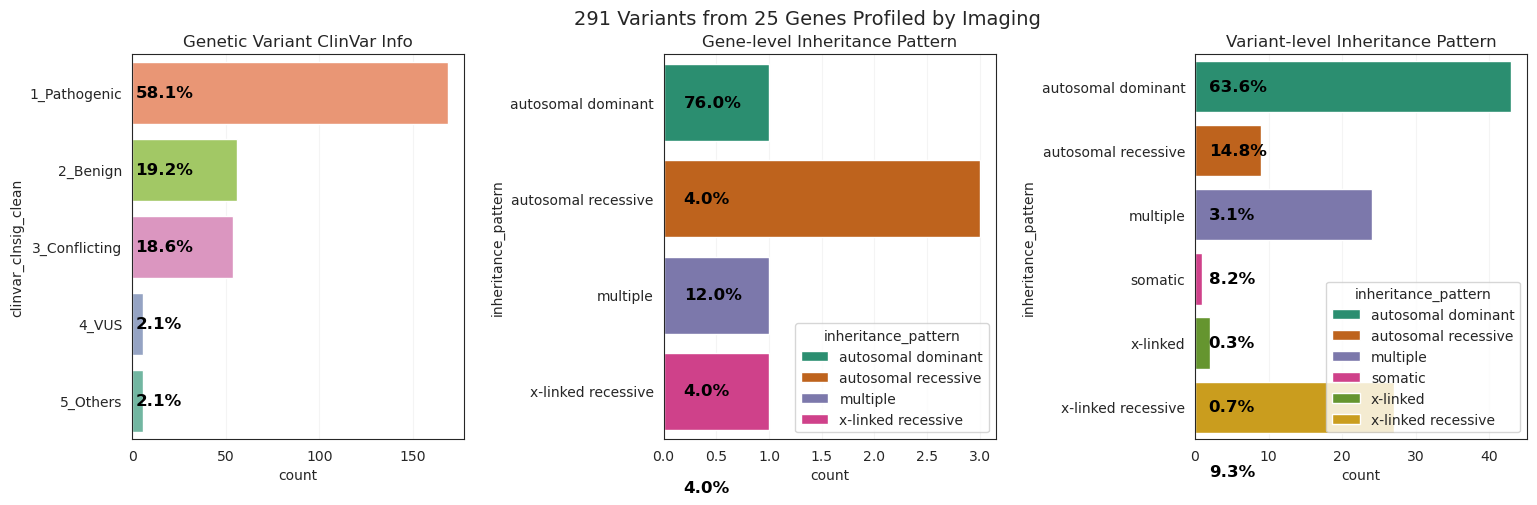

In [245]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
plot_cat_count_perc(
    imaging_summary_clinvar,
    "clinvar_clnsig_clean",
    title="ClinVar",
    ax=axes[0],
    palette=palette_dict["clinvar_clnsig_clean"]
)
axes[0].set_title("Genetic Variant ClinVar Info")

plot_cat_count_perc(
    imaging_summary_clinvar.unique("symbol"),
    "inheritance_pattern",
    title="Inheritance",
    ax=axes[1],
)
axes[1].set_title("Gene-level Inheritance Pattern")

plot_cat_count_perc(
    imaging_summary_clinvar,
    "inheritance_pattern",
    title="Inheritance",
    ax=axes[2],
)
axes[2].set_title("Variant-level Inheritance Pattern")

plt.suptitle(f"{imaging_summary_clinvar.unique('gene_allele').shape[0]} Variants from {imaging_summary_clinvar.unique('symbol').shape[0]} Genes Profiled by Imaging", y=.97, fontsize=14)
plt.subplots_adjust(wspace=.6)
plt.show()

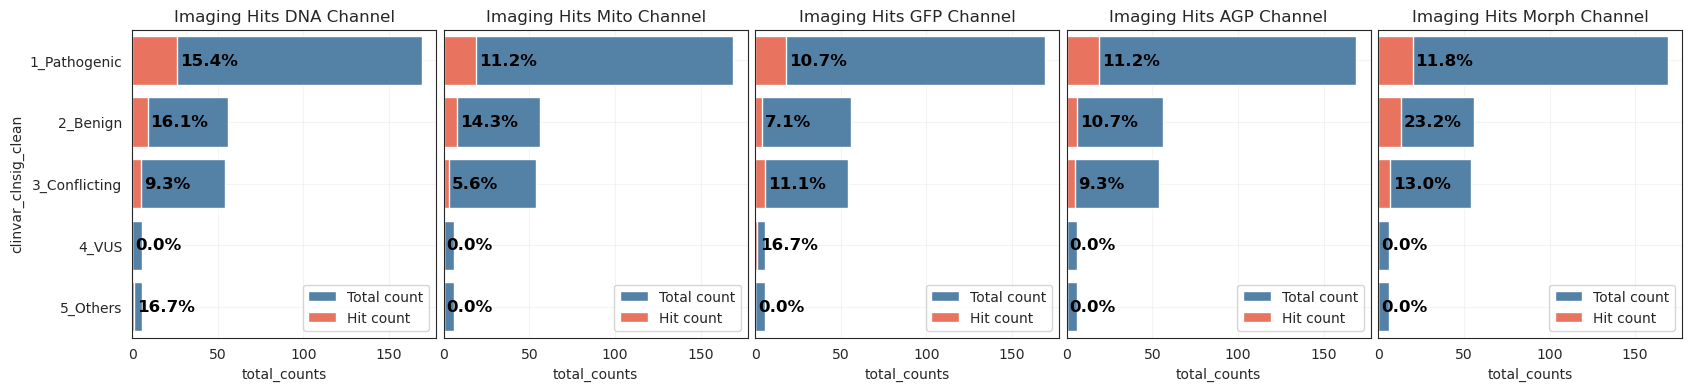

In [246]:
fig, axes = plt.subplots(1,5, figsize=(20,4), sharey=True)
for i, ax in enumerate(axes.flatten()):
    plot_assay_hit_by_category(imaging_summary_clinvar, f"Altered_95th_perc_both_batches_{FEAT_SETS[i]}", 
                               "clinvar_clnsig_clean", f"Imaging Hits {FEAT_SETS[i]} Channel", ax=ax)
plt.subplots_adjust(wspace=.025)
plt.show()

Text(0.5, 1.0, 'Genes Without Mislocalized Variants')

<Figure size 640x480 with 0 Axes>

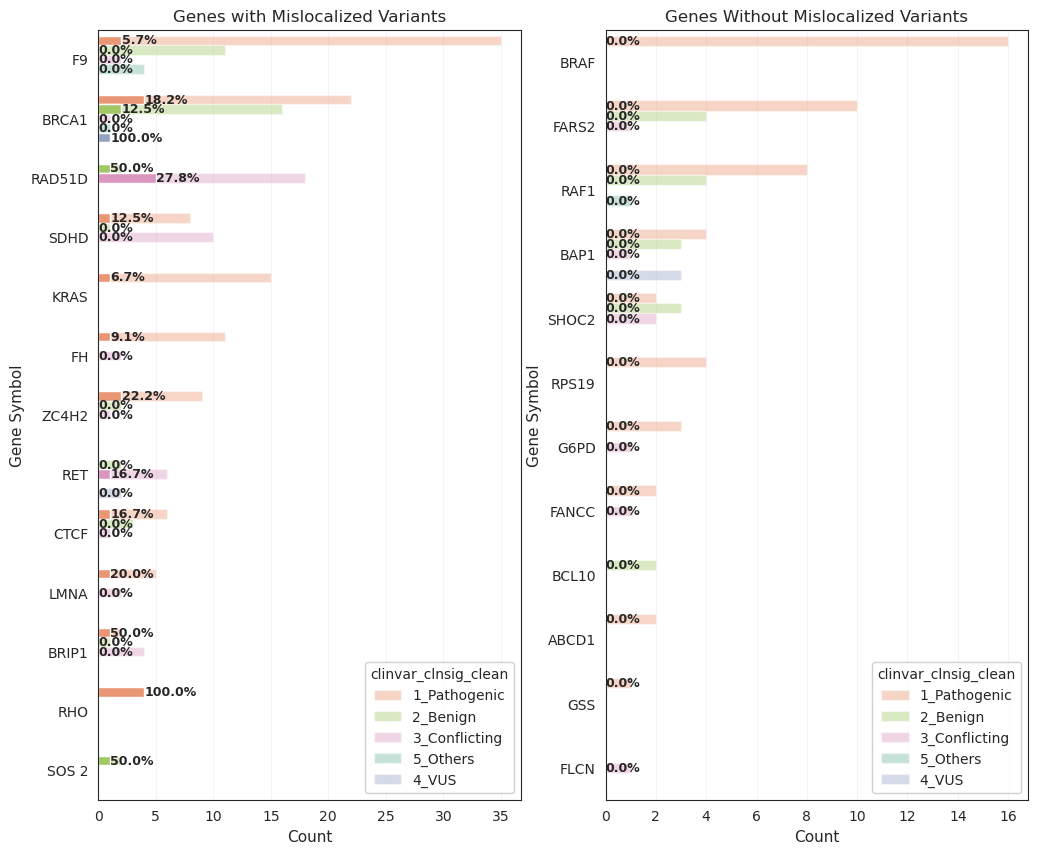

In [247]:
plt.clf()
fig, ax = plt.subplots(1,2,figsize=(12, 10))
plot_gene_level_summary(
    imaging_summary_clinvar.with_columns(
        (
            (pl.col(GFP_MISLOCAL_FEAT_LENIENT)==1)
        ).alias("hit_by_an_assay")
    ).filter(
        pl.col("Gene").is_in(imaging_summary_clinvar_hits["Gene"].unique())
    ),
    assay="hit_by_an_assay", 
    cat="clinvar_clnsig_clean", 
    palette=palette_dict["clinvar_clnsig_clean"],
    ax=ax[0]
)
ax[0].set_title("Genes with Mislocalized Variants")

_ = plot_gene_level_summary(
    imaging_summary_clinvar.with_columns(
        (
            (pl.col(GFP_MISLOCAL_FEAT_LENIENT)==1)
        ).alias("hit_by_an_assay")
    ).filter(
        ~pl.col("Gene").is_in(imaging_summary_clinvar_hits["Gene"].unique())
    ),
    assay="hit_by_an_assay", 
    cat="clinvar_clnsig_clean", 
    palette=palette_dict["clinvar_clnsig_clean"],
    ax=ax[1]
)
ax[1].set_title("Genes Without Mislocalized Variants")

<Figure size 640x480 with 0 Axes>

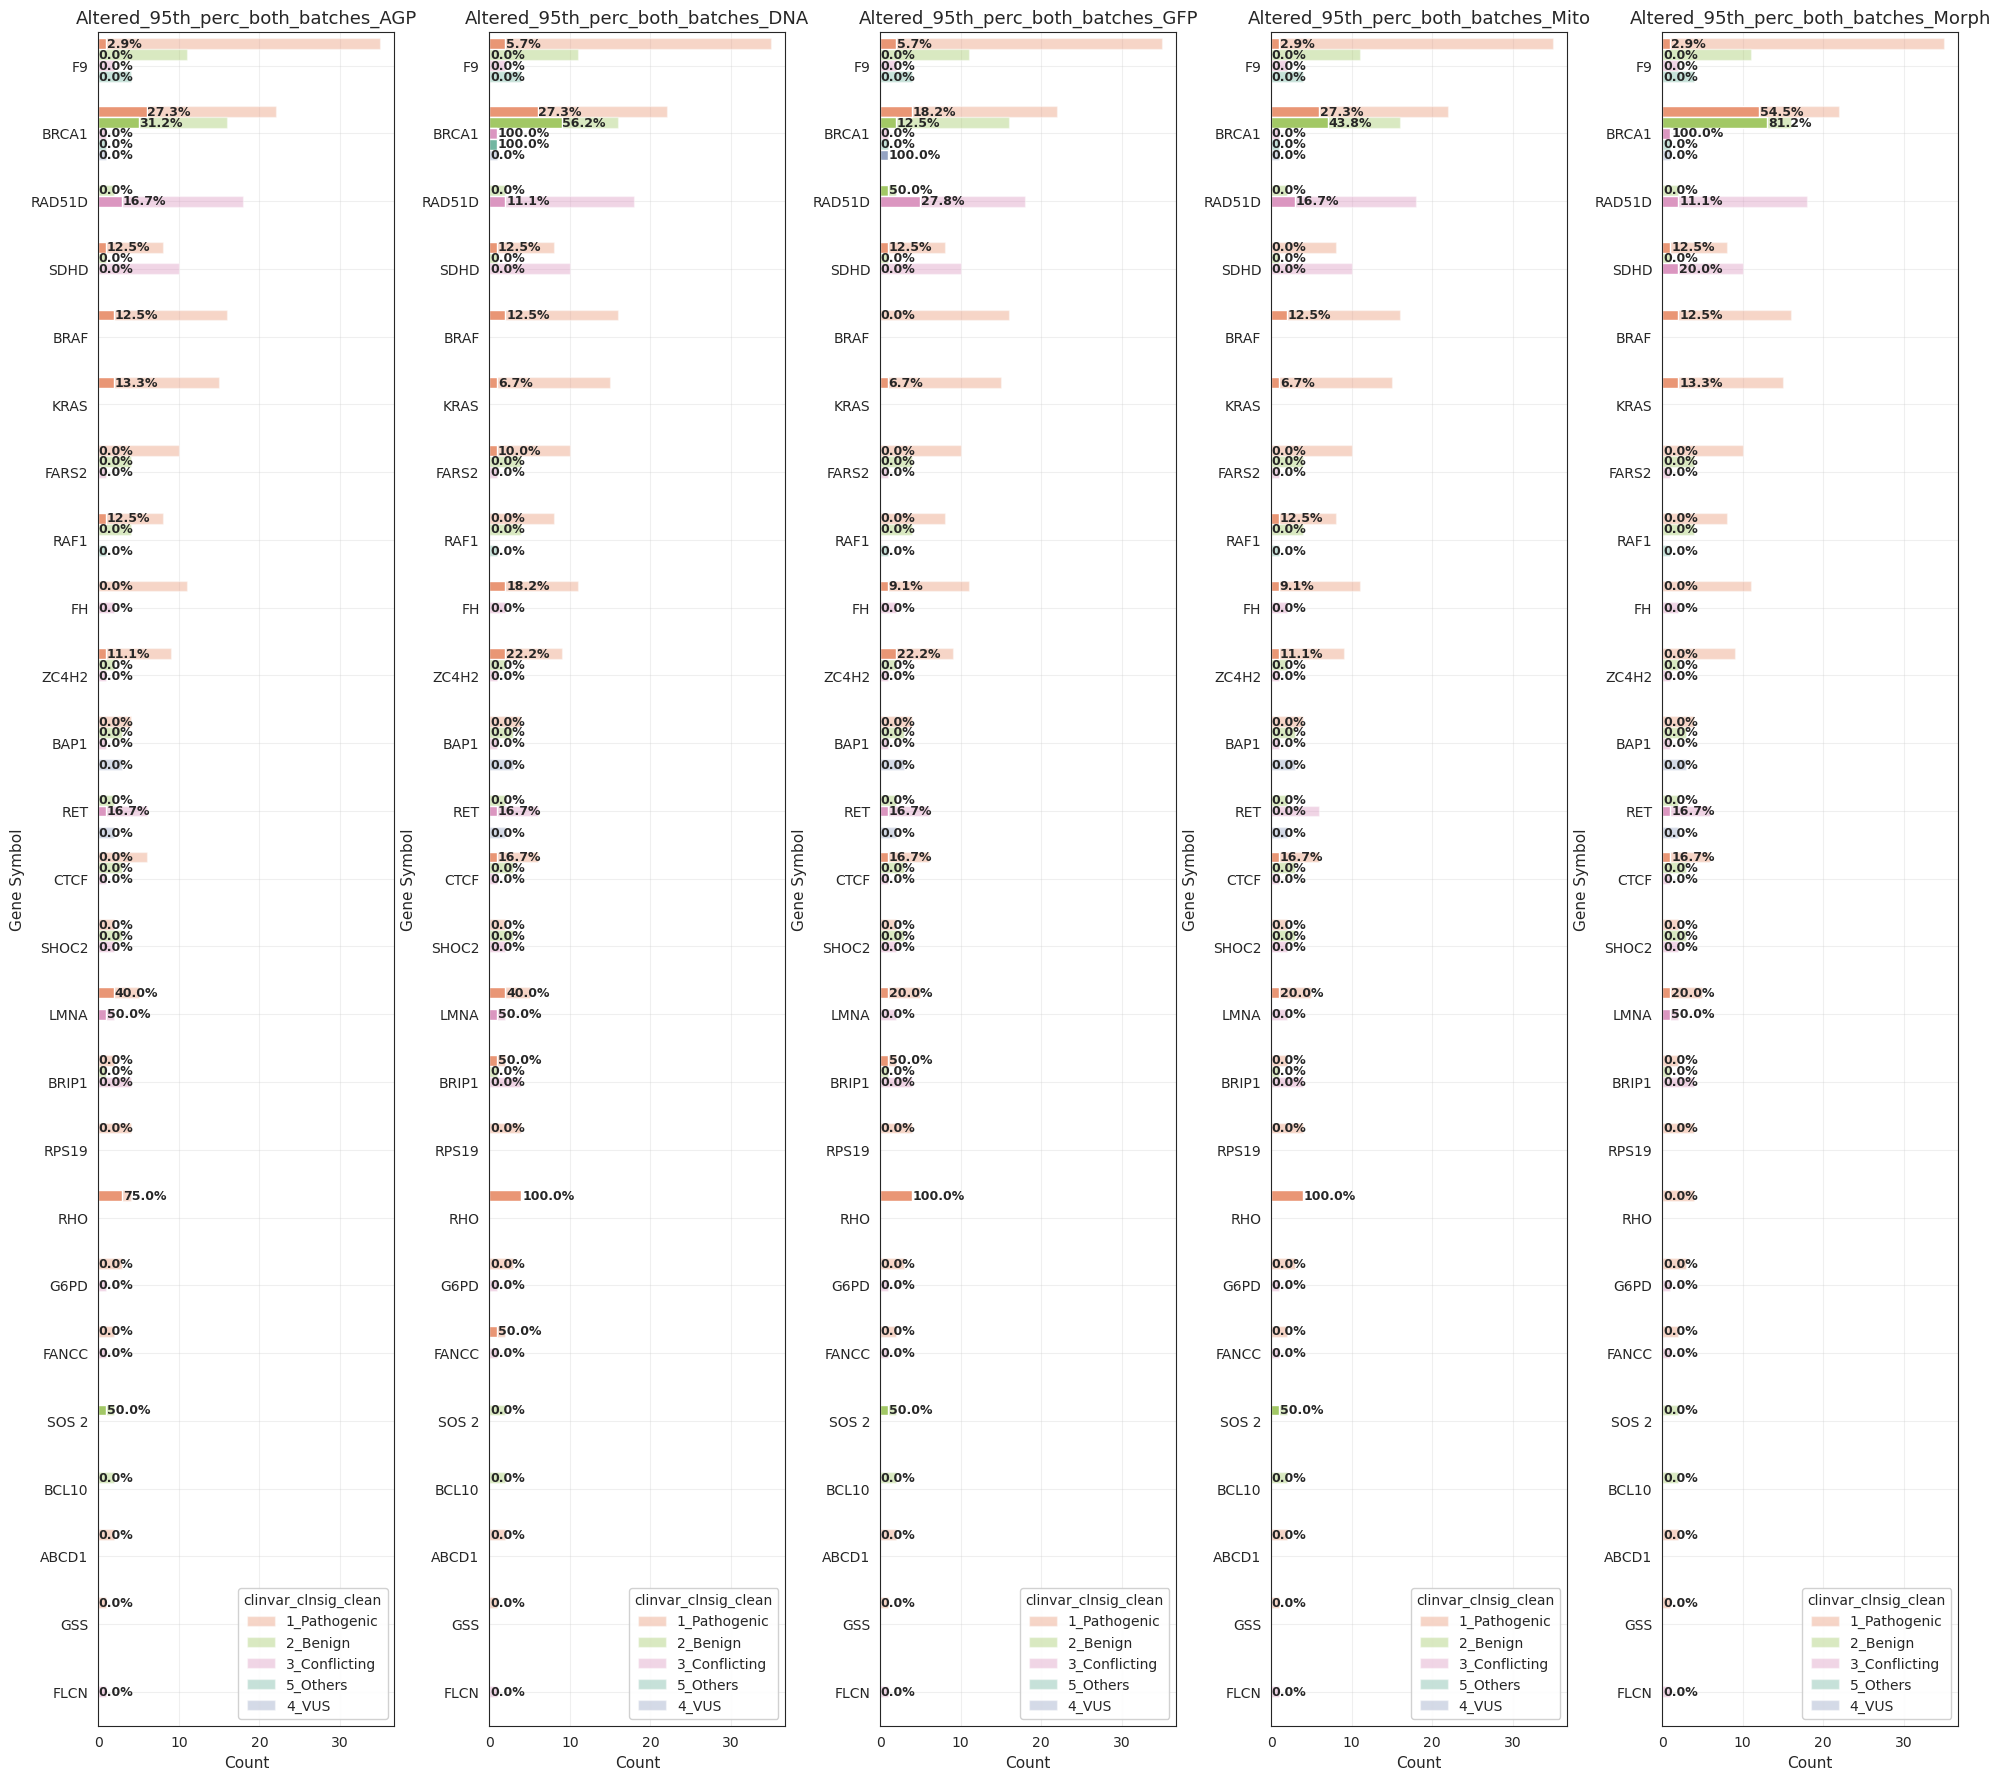

In [248]:
hue_order = sorted(imaging_summary_clinvar.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
gene_order = imaging_summary_clinvar.unique("gene_variant").group_by("Gene").agg(
    pl.len()
).sort("len", descending=False)["Gene"]
auroc_cols = sorted([col for col in imaging_summary_clinvar.columns if col.startswith("AUROC_Mean") and not col.endswith("_right")])
alter_95th_cols = sorted([col for col in imaging_summary_clinvar.columns if col.startswith("Altered_95th_perc") and not col.endswith("_right")])
plt.clf()

fig, ax = plt.subplots(1,5,figsize=(24, 22))
for i, col in enumerate(alter_95th_cols):
    plot_gene_level_summary(imaging_summary_clinvar.unique("gene_variant").with_columns(
        pl.col(col).cast(pl.Boolean).alias(col)
    ), assay=col, ax=ax[i], palette=palette_dict["clinvar_clnsig_clean"]) ## gene_order=gene_order, hits_only=False,, col, col+"\n"
    ax[i].grid(alpha=.3)

plt.subplots_adjust(wspace=.32)
plt.show()

<Figure size 640x480 with 0 Axes>

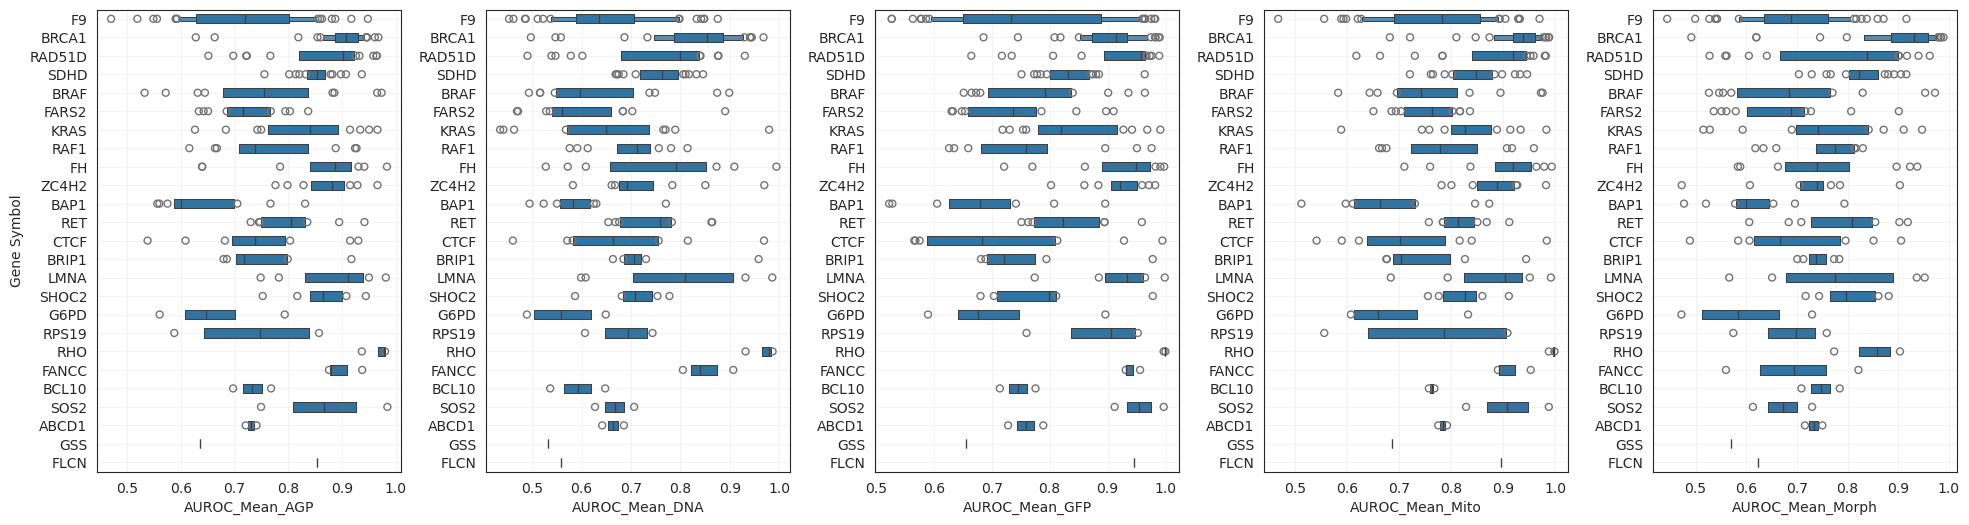

In [249]:
plt.clf()
fig, ax = plt.subplots(1,5,figsize=(24, 6))
for i, col in enumerate(auroc_cols):
    sns.boxenplot(data=imaging_summary_clinvar.unique("gene_variant").to_pandas(), x=col, y="Gene", ax=ax[i], width=.5, 
                 order=gene_order[::-1])
    # ax.set_xlabel("AUROC_Mean_GFP")
    ax[i].set_ylabel("")
    ax[i].grid(alpha=0.2)
ax[0].set_ylabel("Gene Symbol")
plt.subplots_adjust(wspace=.28)
plt.show()

## 3. Pillar overlap

In [377]:
pillar_clinvar_df = pl.read_csv(
    "../../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_gold_standards_080425_processed.csv", 
    infer_schema_length=1000000
)
pillar_clinvar_single_aa_df = pl.read_csv(
    "../../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_gold_standards_080425_snps_only.csv",
    infer_schema_length=1000000
)

### 3.1 Merge by Genomic Position

Text(0.5, 1.0, '123 variants per gene overlapped\nbetween VarChAMP Imaging and Pillar dataset')

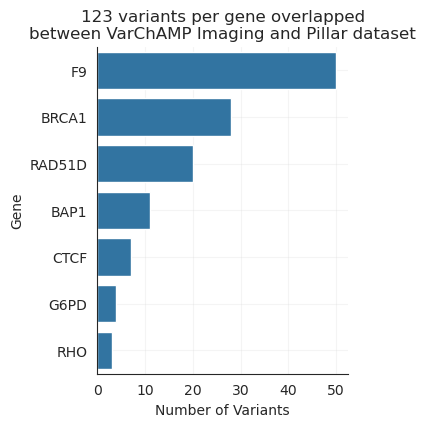

In [436]:
imaging_summary_clinvar_pillar_snp_match_df = imaging_summary_clinvar.with_columns(
    pl.col("nuc_loc").cast(pl.Int64).alias("nuc_loc")
).join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner"
)
# .filter(
#     pl.col("gene_allele")==pl.col("gene_variant_pp")
# )
# .filter(
#     pl.col("Dataset").str.contains("_unpublished")
# )
imaging_summary_clinvar_pillar_snp_match_df.unique("gene_allele").shape

g = sns.catplot(data=imaging_summary_clinvar_pillar_snp_match_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)
g.ax.grid(alpha=.2)
plt.title(f"{imaging_summary_clinvar_pillar_snp_match_df.unique('gene_allele').shape[0]} variants per gene overlapped\nbetween VarChAMP Imaging and Pillar dataset")

#### 3.1.1 Output the overlapped file

In [627]:
## select key cols for output
imaging_summary_clinvar_pillar_snp_match_df_non_null = imaging_summary_clinvar_pillar_snp_match_df.select([
    col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
    if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
])

imaging_summary_clinvar_pillar_snp_match_df_non_null = imaging_summary_clinvar_pillar_snp_match_df.select(
    ["Gene","gene_allele"]+\
    [f"AUROC_Mean_{feat}" for feat in FEAT_SETS]+\
    [f"Altered_95th_perc_both_batches_{feat}" for feat in FEAT_SETS]+\
    [c for c in imaging_summary_clinvar_pillar_snp_match_df.columns if "U2OS_" in c]+\
    [c for c in pillar_clinvar_single_aa_df.columns if c in imaging_summary_clinvar_pillar_snp_match_df.columns and c not in ["Gene","gene_allele"]]
)
# imaging_summary_clinvar_pillar_snp_match_df_non_null.write_csv("../../3_outputs/pillar_img_overlapped_gene_variants.csv")

#### Overall Pillar's Author-reported functional class vs Imaging Mislocalization and Morphology Scores 

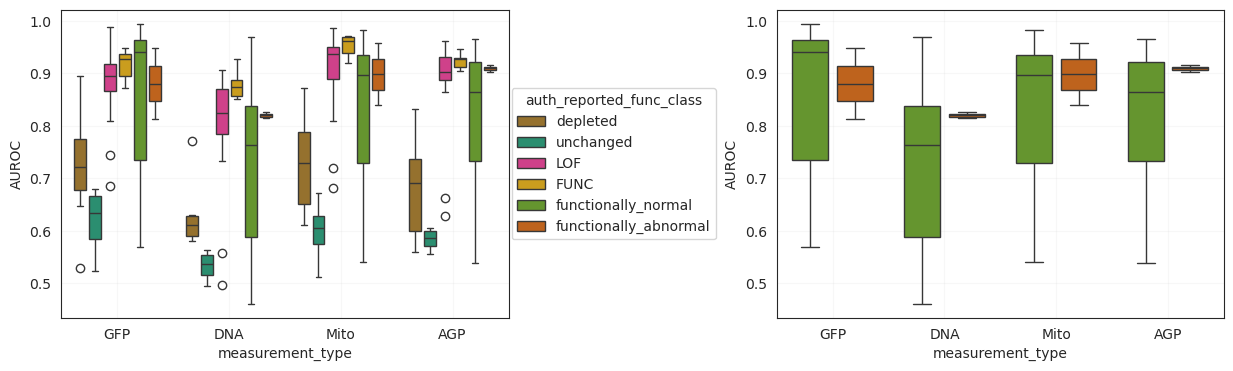

In [465]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
color_palette = dict(zip(
    imaging_summary_clinvar_pillar_snp_match_df["auth_reported_func_class"].sort().unique(),
    sns.color_palette("Dark2")[:len(imaging_summary_clinvar_pillar_snp_match_df["auth_reported_func_class"].unique())]
))
sns.boxplot(
    data=imaging_summary_clinvar_pillar_snp_match_df.select([
        col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
        if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
    ]).unpivot(
       index=["auth_reported_func_class"],
       on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
       variable_name="measurement_type",
       value_name="AUROC"
    ).with_columns(
       pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
    ).to_pandas(),
    x="measurement_type",
    y="AUROC",
    hue="auth_reported_func_class",
    gap=.2,
    palette=color_palette,
    ax=axes[0],
    legend=True
)
axes[0].legend(loc="center right", bbox_to_anchor=(1.48,0.5), title="auth_reported_func_class")
sns.boxplot(
    data=imaging_summary_clinvar_pillar_snp_match_df.filter(
        pl.col("Dataset").str.contains("_unpublished")
    ).select([
        col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
        if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
    ]).unpivot(
       index=["auth_reported_func_class"],
       on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
       variable_name="measurement_type",
       value_name="AUROC"
    ).with_columns(
       pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
    ).to_pandas(),
    x="measurement_type",
    y="AUROC",
    hue="auth_reported_func_class",
    gap=.2,
    palette=color_palette,
    ax=axes[1],
    legend=False
)
plt.subplots_adjust(wspace=.6)
for ax in axes:
    ax.grid(alpha=.15)

### 3.2 Gene by Gene Breakdown

In [630]:
## some files from the 1% manuscript github repo
feat_df = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/3_outputs/feat_importance_gt1e-3_all_alleles.csv")
sc_profile_feat_orig = pl.read_parquet(
    "/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_oneperc.parquet")
sc_profile_feat_orig_b1314 = pl.read_parquet(
    "/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/batch_profiles/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
)
ref_var_cell_all_prof_df = pl.read_parquet(
    "/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_oneperc_int_featselect.parquet")

#### 3.2.1 F9

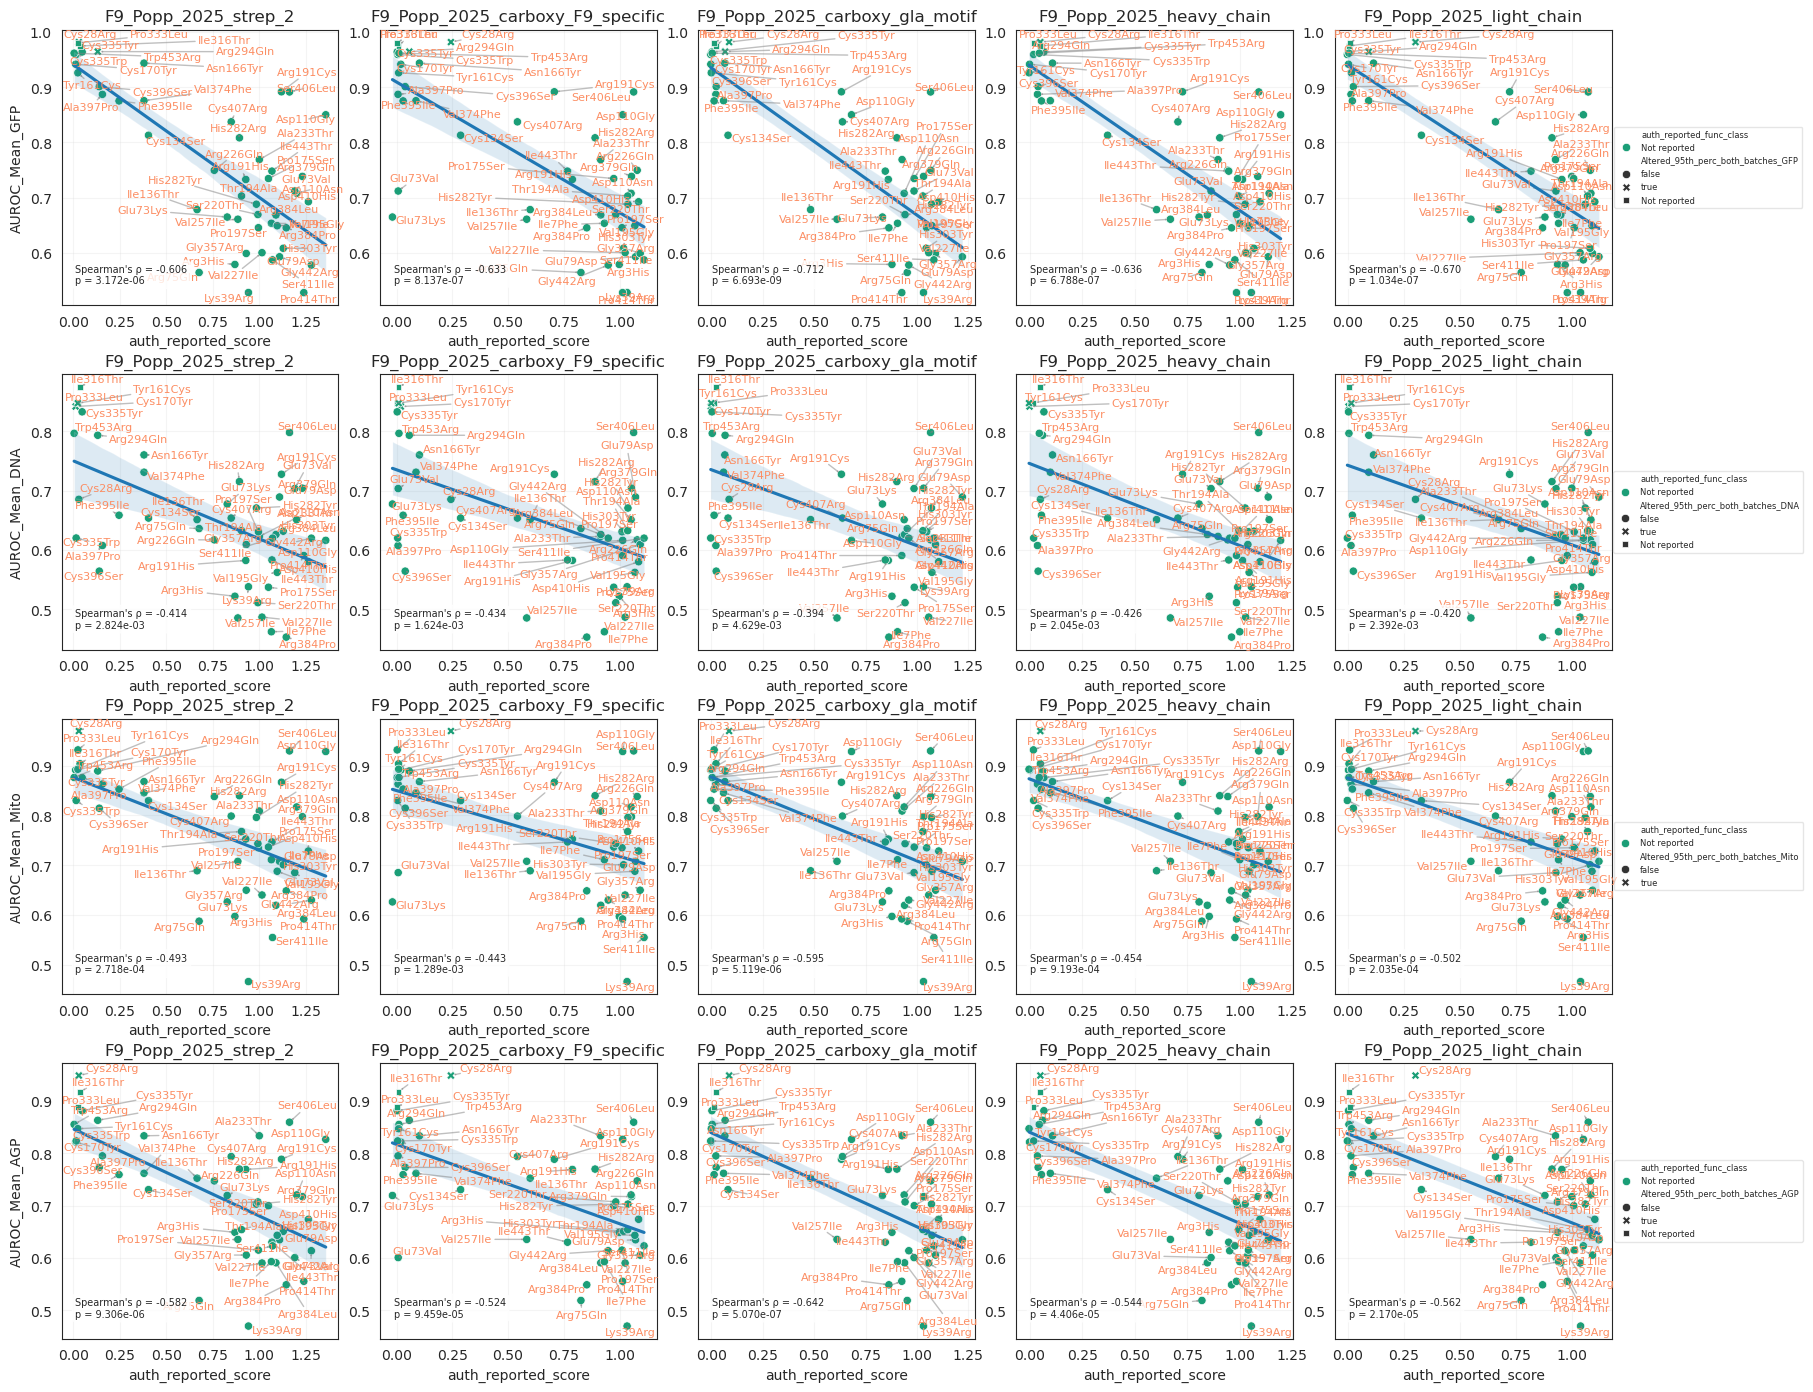

In [466]:
gene = "F9"
imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df_non_null.filter(
    pl.col("Gene")==gene
)
studies_on_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list()
unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique().to_list()

fig, axes = plt.subplots(4, len(studies_on_gene), figsize=(20, 17)) ##sharey=True, 
for j, study in enumerate(studies_on_gene):
   imaging_summary_clinvar_pillar_snp_match_df_gene_study = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
       pl.col("Dataset")==study
   )
   imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.with_columns(
       pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
   )
   for i, feat in enumerate(FEAT_SETS):
       sns.scatterplot(
           data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.with_columns(
               pl.col("auth_reported_func_class").fill_null("Not reported").alias("auth_reported_func_class"),
               pl.col(f"Altered_95th_perc_both_batches_{feat}").fill_null("Not reported").alias(f"Altered_95th_perc_both_batches_{feat}")
           ).to_pandas(),
           x="auth_reported_score",
           y=f"AUROC_Mean_{feat}",
           ax=axes[i, j],
           hue="auth_reported_func_class",
           style=f"Altered_95th_perc_both_batches_{feat}",
           palette="Dark2"
       )
       sns.regplot(
           data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
           x="auth_reported_score",
           y=f"AUROC_Mean_{feat}",
           ax=axes[i, j],
           scatter=False
       )
       if j != len(studies_on_gene)-1:
           axes[i, j].get_legend().remove()
       else:
           axes[i, j].legend(bbox_to_anchor=(1.35, .5), 
                             loc="center",
                             fontsize=6, framealpha=.5, 
                             # bbox_transform=axes[i, -1].transAxes
           )
       # Get pandas dataframe for easier indexing
       plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
       # Add point labels with adjustText
       texts = []
       for idx, row in plot_data.iterrows():
           if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[f"AUROC_Mean_{feat}"])):
               text = axes[i, j].annotate(
                   row["gene_allele"].split('_')[-1],
                   (row["auth_reported_score"], row[f"AUROC_Mean_{feat}"]),
                   fontsize=8,
                   color=clinvar_color_map[clinvar_class]
               )
               texts.append(text)
       adjust_text(texts, ax=axes[i, j], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
       # Calculate Spearman correlation
       mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[f"AUROC_Mean_{feat}"]))
       rho, p_val = spearmanr(
           plot_data["auth_reported_score"][mask], 
           plot_data[f"AUROC_Mean_{feat}"][mask]
       )
       
       # Add correlation text to plot
       axes[i, j].text(
           0.05, 0.15, 
           f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
           fontsize=7,
           transform=axes[i, j].transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
       )
       if j == 0:
           axes[i, j].set_ylabel(f"AUROC_Mean_{feat}")
       else:
           axes[i, j].set_ylabel("")
       axes[i, j].set_title(study)
       axes[i, j].grid(alpha=.2)
       
plt.subplots_adjust(wspace=0.15, hspace=0.25)

<Axes: xlabel='AUROC_Mean_GFP', ylabel='Count'>

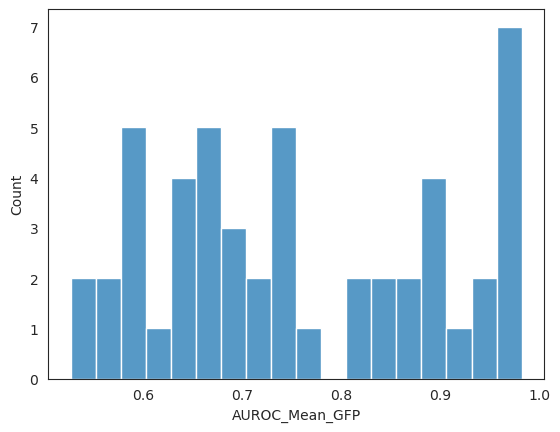

In [629]:
sns.histplot(
    imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_allele").drop_nulls("AUROC_Mean_GFP").to_pandas(),
    x="AUROC_Mean_GFP",
    binwidth=0.025
)

Text(0.5, 1.0, 'XGBClassifier_Feature_Importance')

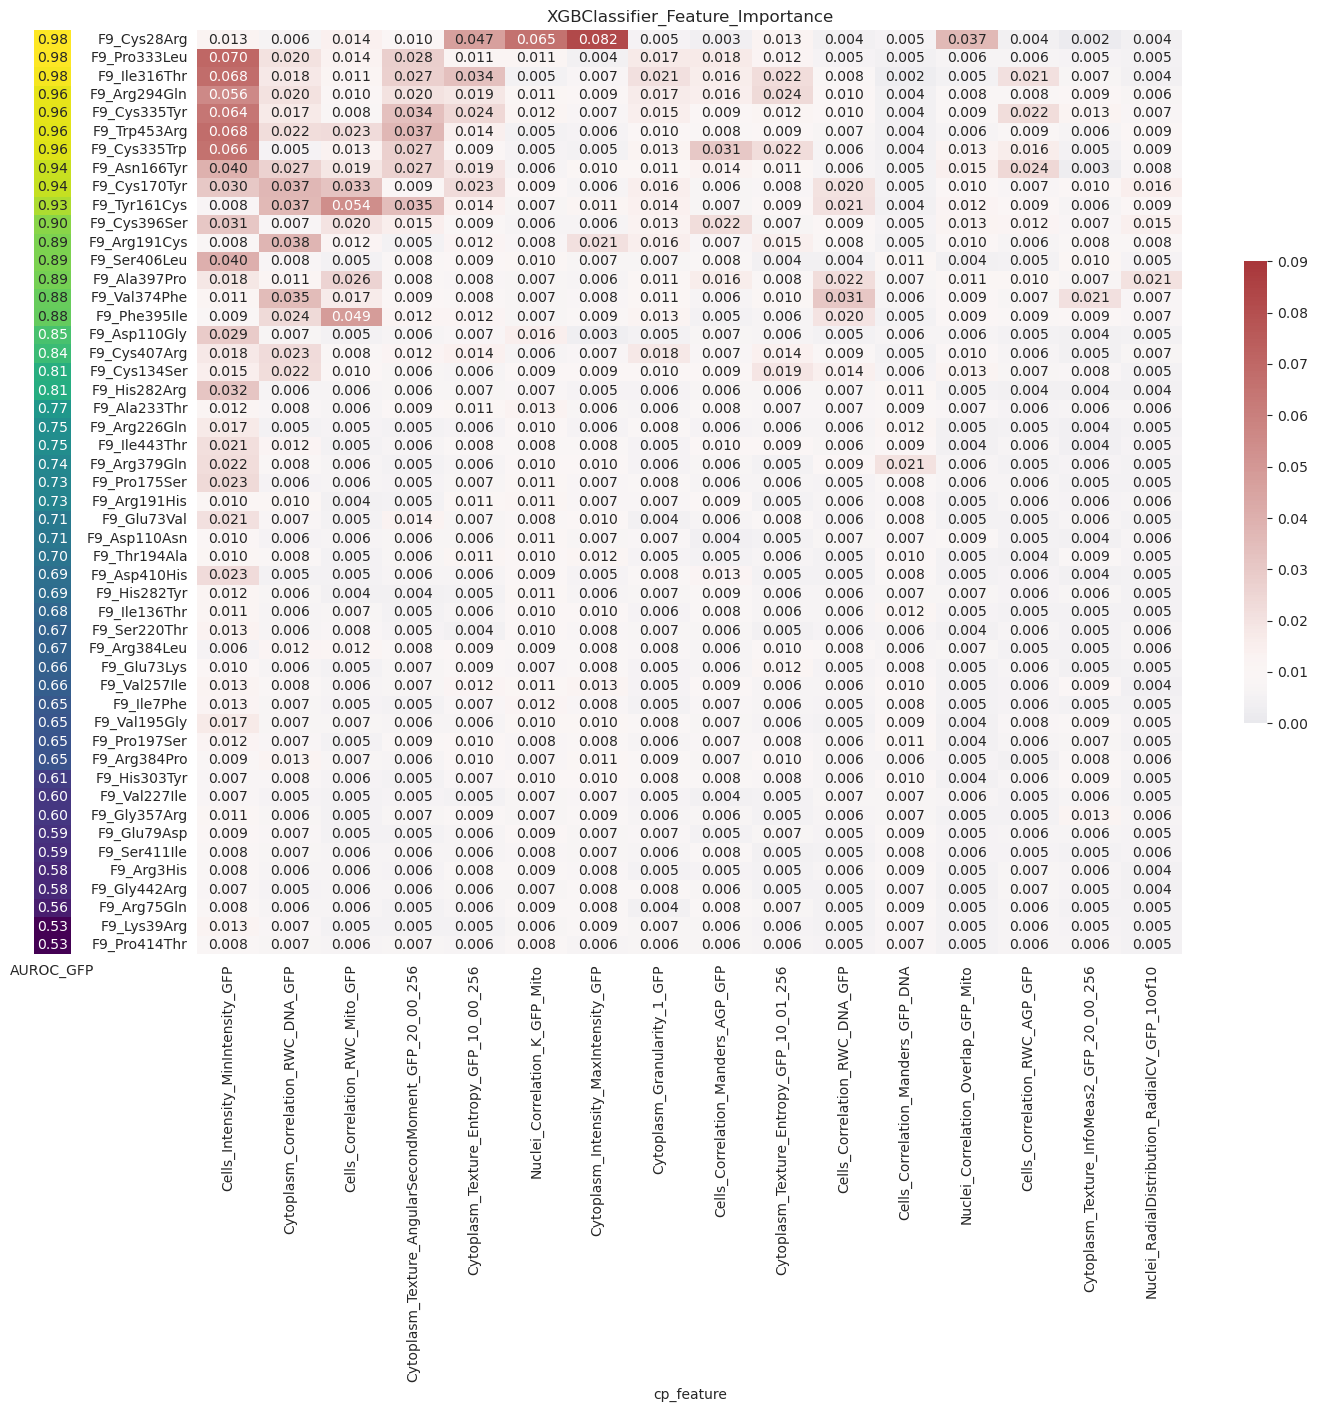

In [550]:
sorted_unique_variants = imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_allele").sort(
    "AUROC_Mean_GFP", descending=True
)["gene_allele"].to_list()

## grep the top features to look at
# get_top_feats = feat_df[["cp_feature"]+[idx for idx in feat_df.columns if gene in idx]].with_columns(
#     pl.mean_horizontal(
#         pl.col(sorted_unique_variants)
#     ).alias('row_mean')
# ).sort(sorted_unique_variants, descending=True)["cp_feature"].to_list()[-10:][::-1]

## get the features with max_feat_importance > 0.01 in any variant
get_top_feats = feat_df.with_columns(
    pl.mean_horizontal(
        pl.col(sorted_unique_variants)
    ).alias('row_mean')
).select(
    ["cp_feature","row_mean"]+[idx for idx in feat_df.columns if gene in idx]
).filter(
   pl.max_horizontal(sorted_unique_variants) >= .02 #0.015
).sort("row_mean", descending=True)["cp_feature"].to_list()

your_score_array = imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_allele").sort(
    "AUROC_Mean_GFP", descending=True
)["AUROC_Mean_GFP"].to_numpy()

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(1, 2, width_ratios=[0.03, 1], wspace=.2)

# Left side: score bar
ax_left = fig.add_subplot(gs[:, 0])
score_data = your_score_array.reshape(-1, 1)
sns.heatmap(score_data, ax=ax_left, annot=True, cbar=False, cmap="viridis",
            yticklabels=False, xticklabels=['AUROC_GFP'], fmt='.2f')

# Main heatmap
ax_main = fig.add_subplot(gs[:, 1])
sns.heatmap(
  data=feat_df.to_pandas().set_index("cp_feature").loc[get_top_feats,sorted_unique_variants].T,
  # square=True,
  ax=ax_main,
  cmap="vlag",
    center=0.01, vmin=0, vmax=0.09,
  cbar_kws={"shrink": 0.5},
    yticklabels=1,
    xticklabels=1,
    annot=True, fmt='.3f'
)
ax_main.set_ylabel('')
ax_main.set_title("XGBClassifier_Feature_Importance")

100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


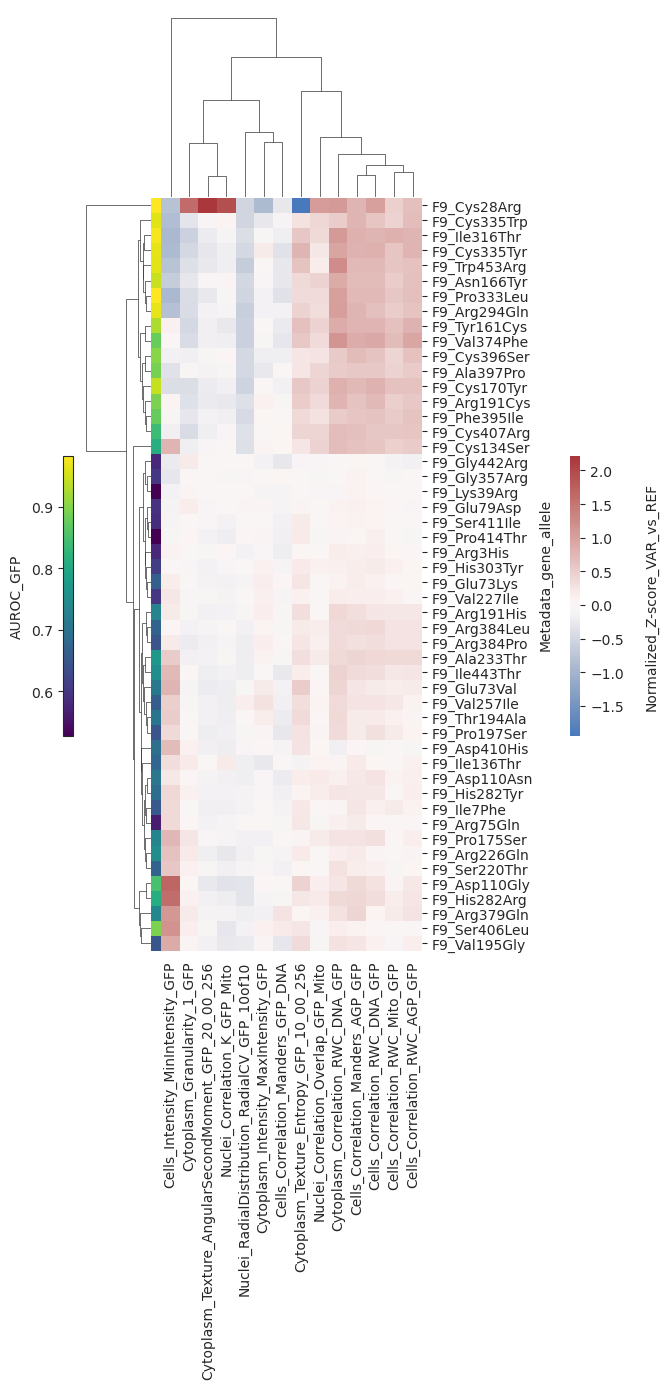

In [631]:
ref_var_cell_all_prof_df = sc_profile_feat_orig_b1314
norm_vars_feat_df, norm_var_sc_feat_df = pl.DataFrame(), pl.DataFrame()
sig_diff_feat = [feat for feat in get_top_feats if feat in ref_var_cell_all_prof_df.columns]

for gene in tqdm(["F9"]):
    gene_mean = ref_var_cell_all_prof_df.filter(pl.col("Metadata_gene_allele")==gene).select(sig_diff_feat).mean().to_numpy()[0].tolist()
    gene_std = ref_var_cell_all_prof_df.filter(pl.col("Metadata_gene_allele")==gene).select(sig_diff_feat).std().to_numpy()[0].tolist()
    
    z_norm_var_sc_feat_df = ref_var_cell_all_prof_df.filter(
        (pl.col("Metadata_gene_allele").str.starts_with(f"{gene}_"))
        &(pl.col("Metadata_gene_allele")!=gene)
        &(pl.col("Metadata_gene_allele").is_in(imaging_summary_clinvar["gene_allele"].unique()))
    ).with_columns(
        [((pl.col(col) - pl.lit(gene_mean[i])) / pl.lit(gene_std[i])).alias(col)
        for i, col in enumerate(sig_diff_feat)]
    )
    
    norm_var_sc_feat_df = pl.concat([
        norm_var_sc_feat_df,
        z_norm_var_sc_feat_df
    ])
    
    z_norm_var_feat_df = z_norm_var_sc_feat_df.group_by(
        "Metadata_gene_allele", "Metadata_Plate", "Metadata_Well" ## aggregate by well first
    ).agg(
        pl.col(col).mean().alias(col)
        for col in sig_diff_feat
    ).group_by(
        "Metadata_gene_allele" ## aggregate by allele
    ).agg(
        pl.col(col).median().alias(col)
        for col in sig_diff_feat
    )#.to_pandas().set_index("Metadata_gene_allele")[sig_diff_feat]
    
    norm_vars_feat_df = pl.concat([norm_vars_feat_df, 
                                   z_norm_var_feat_df], 
                                  how="diagonal")

from matplotlib.colors import Normalize

# df_with_scores = pd.DataFrame(your_score_array, index=sorted_unique_variants, columns=['AUROC_GFP'])
# Create a pandas Series with proper index
row_colors_series = pd.Series(your_score_array, index=sorted_unique_variants, name='AUROC_GFP')

# Map to colors
norm = Normalize(vmin=row_colors_series.min(), vmax=row_colors_series.max())
cmap = plt.cm.viridis
row_colors = cmap(norm(row_colors_series.values))

# Create clustermap with custom colorbar positions
g = sns.clustermap(
   data=norm_vars_feat_df.to_pandas().set_index("Metadata_gene_allele").loc[sorted_unique_variants,[c for c in get_top_feats if c in norm_vars_feat_df.columns]],
   cmap="vlag", center=0,
   row_colors=row_colors,
   cbar_pos=(1.005, 0.47, 0.02, 0.2),  # (left, bottom, width, height) - smaller, center right,
    yticklabels=1, xticklabels=1,
    figsize=(5,14)
)

# Add label to main heatmap colorbar
g.cax.set_ylabel('Normalized_Z-score_VAR_vs_REF', rotation=90, labelpad=15)

# Add colorbar for row colors on center left
row_cbar_ax = g.fig.add_axes([-.01, 0.47, 0.02, 0.2])  # smaller, center left
row_cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=row_cbar_ax)
row_cbar.set_label('AUROC_GFP', rotation=90, labelpad=5)
row_cbar.ax.yaxis.set_label_position('left')
row_cbar.ax.yaxis.tick_left()

In [ ]:
# fig, axes = plt.subplots(1,5,figsize=(15,20))
# for i, feat in enumerate(get_top_feats[:2]:
#     sns.boxplot(
#         data=sc_profile_feat_orig.filter(
#             pl.col("Metadata_gene_allele").str.contains(gene)
#         ).to_pandas(),
#         x="Metadata_gene_allele",
#         y=feat,
#         showfliers=False,
#         order=sorted(sc_profile_feat_orig.filter(
#             pl.col("Metadata_gene_allele").str.contains(gene)
#         )["Metadata_gene_allele"].unique())
#         # hue="Metadata_gene_allele",
#         # hue_order=sorted(sc_profile_feat_orig.filter(
#         #     pl.col("Metadata_gene_allele").str.contains("BAP1")
#         # )["Metadata_gene_allele"].unique())
#     )
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#     # Add mean points
#     data_for_plot = sc_profile_feat_orig.filter(
#        pl.col("Metadata_gene_allele").str.contains(gene)
#     ).to_pandas()
    
#     means = data_for_plot.groupby("Metadata_gene_allele")[feat].mean()
#     order = sorted(sc_profile_feat_orig.filter(
#        pl.col("Metadata_gene_allele").str.contains(gene)
#     )["Metadata_gene_allele"].unique())
#     for i, allele in enumerate(order):
#        ax.scatter(i, means[allele], color='red', s=50, marker='D', zorder=10)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#     # sns.displot(
#     #     data=sc_profile_feat_orig_b1314.filter(
#     #         pl.col("Metadata_gene_allele").is_in(['G6PD', 'G6PD_Arg365His', 'G6PD_Ile48Thr', 'G6PD_Gly378Ser', 'G6PD_Glu398Lys'])
#     #     ).to_pandas(),
#     #     x="Cytoplasm_Correlation_RWC_DNA_GFP",
#     #     hue="Metadata_gene_allele",
#     #     common_norm=False,
#     #     kde=True
#     # )

#### 3.2.2 Other genes

['BAP1_Cys91Gly', 'BAP1_Leu49Pro', 'BAP1_Asn290Ser', 'BAP1_Cys91Ser', 'BAP1_Pro12Thr', 'BAP1_Thr423Lys', 'BAP1_Thr93Ala', 'BAP1_Glu31Lys', 'BAP1_Arg59Pro', 'BAP1_Arg718Gln', 'BAP1_Ser596Gly']
['BRCA1_Cys44Tyr', 'BRCA1_Thr581Ile', 'BRCA1_Cys64Ser', 'BRCA1_Arg71Gly', 'BRCA1_His41Arg', 'BRCA1_Met1Ile', 'BRCA1_Gly666Val', 'BRCA1_Met548Ile', 'BRCA1_Gly602Ala', 'BRCA1_Phe558Ser', 'BRCA1_Phe591Leu', 'BRCA1_Lys502Glu', 'BRCA1_Met1Thr', 'BRCA1_Met671Lys', 'BRCA1_Thr587Arg', 'BRCA1_Thr37Lys', 'BRCA1_Pro533Leu', 'BRCA1_Val632Ala', 'BRCA1_Arg71Lys', 'BRCA1_Glu631Lys', 'BRCA1_Leu660Pro', 'BRCA1_Cys61Gly', 'BRCA1_Cys39Arg', 'BRCA1_Pro510Ser', 'BRCA1_Asp67Tyr', 'BRCA1_Cys64Tyr', 'BRCA1_Ser611Arg', 'BRCA1_Thr581Ala']
['CTCF_Arg342Gly', 'CTCF_His455Gln', 'CTCF_Arg567Trp', 'CTCF_Tyr407Cys', 'CTCF_Arg567Leu', 'CTCF_Arg342Cys', 'CTCF_Ala697Thr']
['G6PD_Arg365His', 'G6PD_Gly378Ser', 'G6PD_Ile48Thr', 'G6PD_Glu398Lys']
['RAD51D_Glu307Lys', 'RAD51D_Phe305Leu', 'RAD51D_Arg165Gln', 'RAD51D_Val28Leu', 'RAD51D_Va

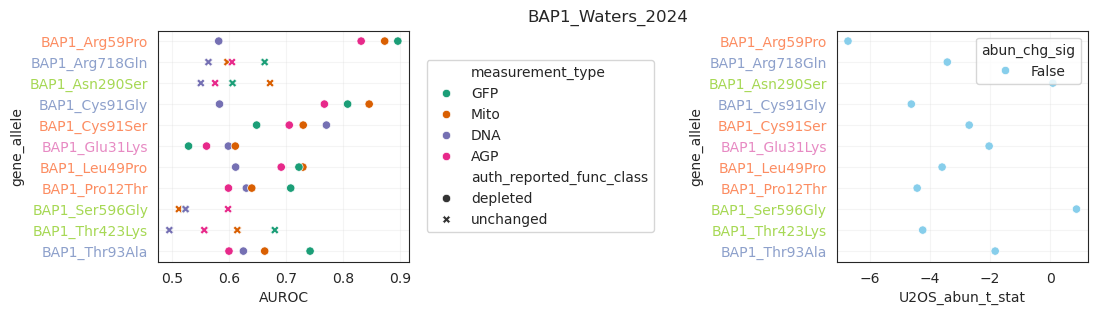

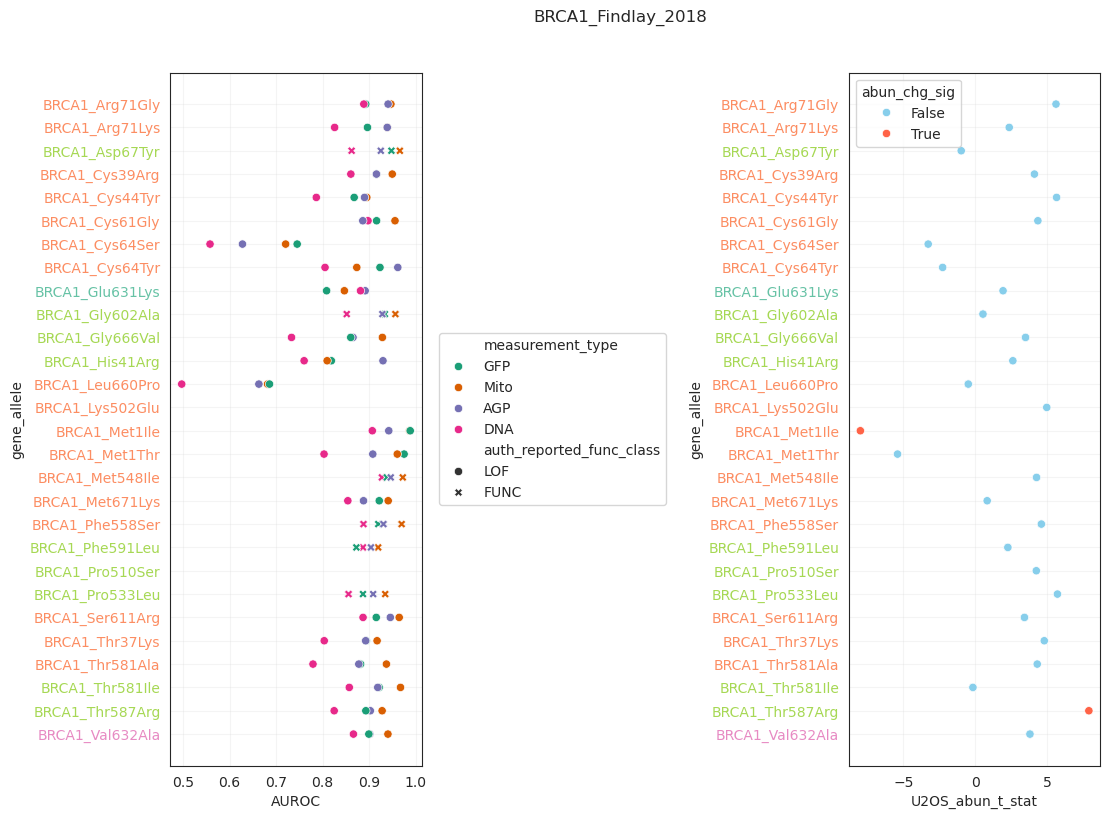

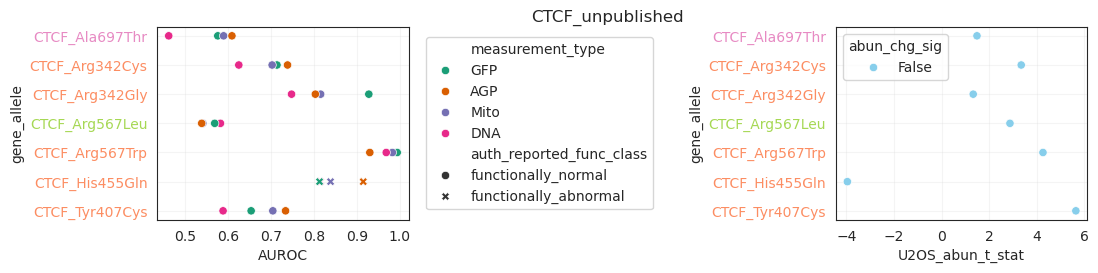

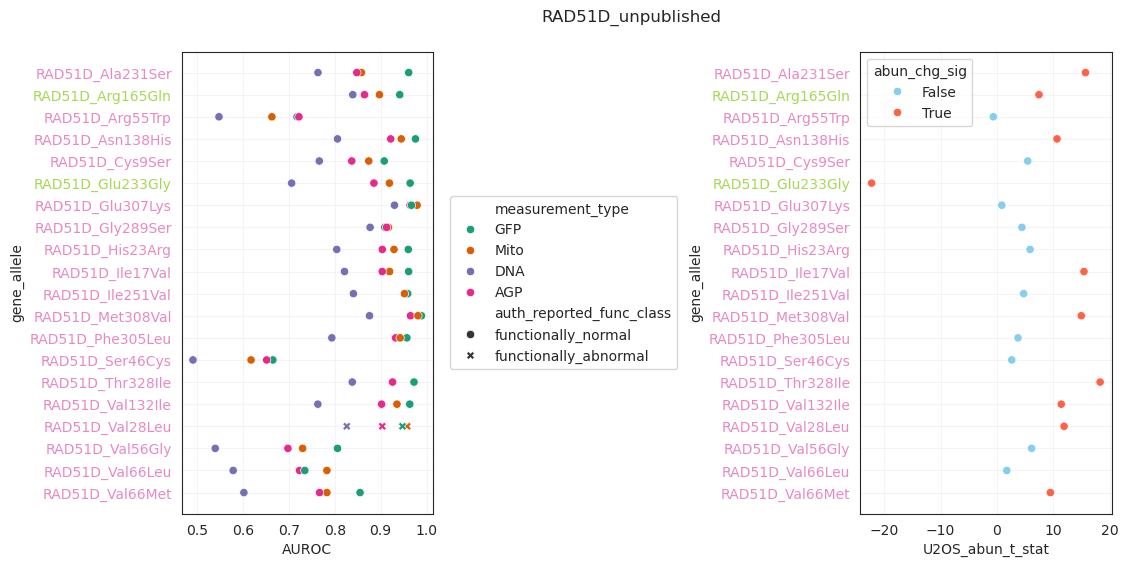

In [382]:
clinvar_color_map = palette_dict["clinvar_clnsig_clean"]
for gene in sorted(imaging_summary_clinvar_pillar_snp_match_df.unique("Gene")["Gene"]):
    if gene == "F9":
        continue
    imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df.filter(
        pl.col("Gene")==gene
    )
    studies_on_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list()
    unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique().to_list()
    print(unique_variants_per_gene)
    # print(gene, "Studies on gene:", )
    # display(
    #     imaging_summary_clinvar_pillar_snp_match_df_gene.select([
    #         col for col in imaging_summary_clinvar_pillar_snp_match_df_gene.columns 
    #         if imaging_summary_clinvar_pillar_snp_match_df_gene.select(pl.col(col).is_null().all()).item() is False
    #     ])
    # )
    if gene == "BRCA1":
        studies_on_gene = [study for study in studies_on_gene if "Findlay" in study]
        
    imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene.select([
        col for col in imaging_summary_clinvar_pillar_snp_match_df_gene.columns 
        if imaging_summary_clinvar_pillar_snp_match_df_gene.select(pl.col(col).is_null().all()).item() is False
    ])
    if "auth_reported_func_class" in imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, max(2.5,len(unique_variants_per_gene)//3)))
        plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene.unpivot(
           index=["gene_allele","auth_reported_func_class", "clinvar_clnsig_clean"],
           on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
           variable_name="measurement_type",
           value_name="AUROC"
        ).with_columns(
           pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
        ).to_pandas()
        sns.scatterplot(
            data=plot_data.sort_values("gene_allele"),
            y="gene_allele",
            x="AUROC",
            hue="measurement_type",
            style="auth_reported_func_class",
            ax=axes[0],
            palette="Dark2",
            # order=sorted(imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique())
        )
        sns.scatterplot(
            data=imaging_summary_clinvar_pillar_snp_match_df_gene.with_columns(
                (pl.col("U2OS_abun_t_pval")*imaging_summary_clinvar.shape[0]).alias("adj_pval")
            ).with_columns(
                pl.when(pl.col("adj_pval")<0.05)
                .then(True)
                .otherwise(False)
                .alias("abun_chg_sig")
            ).sort("gene_allele").to_pandas(),
            x="U2OS_abun_t_stat",
            y="gene_allele",
            hue="abun_chg_sig",
            palette={True: "tomato", False: "skyblue"},
            ax=axes[1],
            # order=sorted(imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique())
        )
        for ax in axes:
            ax.grid(alpha=.2)
        axes[0].legend(loc="center right", bbox_to_anchor=(2.,0.5))
        # Color the y-axis tick labels based on clinvar classification
        for tick, gene_allele in zip(axes[0].get_yticklabels(), plot_data["gene_allele"]):
            clinvar_class = plot_data[plot_data["gene_allele"]==gene_allele]['clinvar_clnsig_clean'].iloc[0]
            tick.set_color(clinvar_color_map[clinvar_class])
        for tick, gene_allele in zip(axes[1].get_yticklabels(), plot_data["gene_allele"]):
            clinvar_class = plot_data[plot_data["gene_allele"]==gene_allele]['clinvar_clnsig_clean'].iloc[0]
            tick.set_color(clinvar_color_map[clinvar_class])
        plt.suptitle(studies_on_gene[0],y=.95)
        plt.subplots_adjust(wspace=1.7)
        # break
    # else:
    #     fig, axes = plt.subplots(1, 5, figsize=(17, 3.5)) ##sharey=True, 
    #     imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene.select([
    #         col for col in imaging_summary_clinvar_pillar_snp_match_df_gene.columns 
    #         if imaging_summary_clinvar_pillar_snp_match_df_gene.select(pl.col(col).is_null().all()).item() is False
    #     ]).with_columns(
    #         pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
    #     )
    #     for j, feat in enumerate(FEAT_SETS):
    #         sns.regplot(
    #             data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
    #             y="auth_reported_score",
    #             x=f"AUROC_Mean_{feat}",
    #             ax=axes[j],
    #             ci=False
    #         )
    #         # Get pandas dataframe for easier indexing
    #         plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
    #         # Add point labels with adjustText
    #         texts = []
    #         for idx, row in plot_data.iterrows():
    #            if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[f"AUROC_Mean_{feat}"])):
    #                text = axes[j].annotate(
    #                    row["gene_allele"].split('_')[-1],
    #                    (row[f"AUROC_Mean_{feat}"], row["auth_reported_score"]),  # Swapped coordinates
    #                    fontsize=7,
    #                    color=clinvar_color_map[row["clinvar_clnsig_clean"]]
    #                )
    #                texts.append(text)
    #         adjust_text(texts, ax=axes[j], arrowprops=dict(arrowstyle='->', alpha=0.5))
    #         # Calculate Spearman correlation
    #         mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[f"AUROC_Mean_{feat}"]))
    #         rho, p_val = spearmanr(
    #            plot_data["auth_reported_score"][mask], 
    #            plot_data[f"AUROC_Mean_{feat}"][mask]
    #         )
    #         # Add correlation text to plot
    #         axes[j].text(
    #            0.03, 0.15, 
    #            f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
    #            transform=axes[j].transAxes,
    #            verticalalignment='top', fontsize=7,
    #            # bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    #         )
    #         if j == 0:
    #            axes[j].set_ylabel(f"auth_reported_score")
    #         else:
    #            axes[j].set_ylabel("")
    #         axes[j].grid(alpha=.2)
    #     plt.suptitle(studies_on_gene[0],y=.95)
    #     plt.subplots_adjust(wspace=0.2)

['Nuclei_RadialDistribution_MeanFrac_GFP_10of10', 'Nuclei_Correlation_K_GFP_Mito', 'Cells_Texture_InfoMeas1_GFP_5_02_256', 'Cytoplasm_Texture_AngularSecondMoment_GFP_20_01_256', 'Cytoplasm_Intensity_MaxIntensity_GFP', 'Nuclei_Correlation_RWC_Mito_GFP', 'Cells_Texture_InfoMeas1_GFP_10_00_256', 'Cytoplasm_Correlation_RWC_DNA_GFP', 'Cells_Texture_InfoMeas1_GFP_10_01_256', 'Nuclei_Granularity_1_GFP']


/tmp/ipykernel_53802/1166352273.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_53802/1166352273.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


[Text(0, 0, 'RAD51D'),
 Text(1, 0, 'RAD51D_Ala231Ser'),
 Text(2, 0, 'RAD51D_Arg165Gln'),
 Text(3, 0, 'RAD51D_Arg55Trp'),
 Text(4, 0, 'RAD51D_Asn138His'),
 Text(5, 0, 'RAD51D_Cys9Ser'),
 Text(6, 0, 'RAD51D_Glu233Gly'),
 Text(7, 0, 'RAD51D_Glu307Lys'),
 Text(8, 0, 'RAD51D_Gly289Ser'),
 Text(9, 0, 'RAD51D_His23Arg'),
 Text(10, 0, 'RAD51D_Ile17Val'),
 Text(11, 0, 'RAD51D_Ile251Val'),
 Text(12, 0, 'RAD51D_Met308Val'),
 Text(13, 0, 'RAD51D_Phe305Leu'),
 Text(14, 0, 'RAD51D_Ser46Cys'),
 Text(15, 0, 'RAD51D_Thr328Ile'),
 Text(16, 0, 'RAD51D_Val132Ile'),
 Text(17, 0, 'RAD51D_Val28Leu'),
 Text(18, 0, 'RAD51D_Val56Gly'),
 Text(19, 0, 'RAD51D_Val66Leu'),
 Text(20, 0, 'RAD51D_Val66Met')]

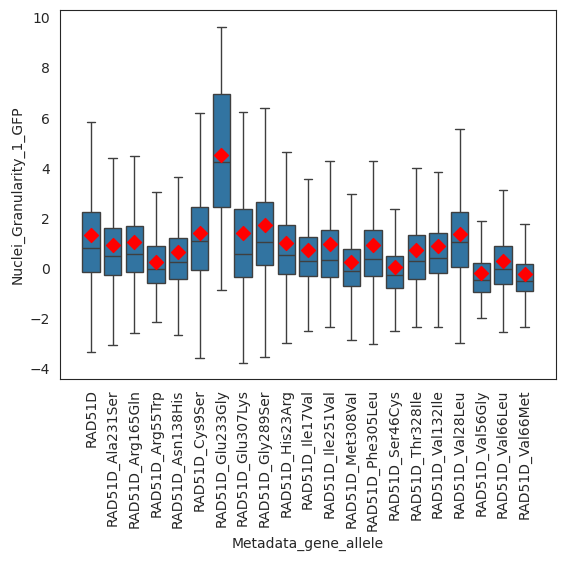

In [633]:
print(feat_df[["cp_feature"]+[idx for idx in feat_df.columns if "RAD51D" in idx]].with_columns(
    pl.mean_horizontal(pl.col(
        ['RAD51D_Glu233Gly',
        # 'RAD51D-Ala231Ser',
        # 'RAD51D-Glu307Lys',
        # 'RAD51D-Ile251Val',
        # 'RAD51D-Val132Ile',
        # 'RAD51D-Arg55Trp',
        # 'RAD51D-Cys9Ser',
        # 'RAD51D-Val66Met',
        # 'RAD51D-His23Arg',
        # 'RAD51D-Gly289Ser',
        # 'RAD51D-Phe305Leu',
        # 'RAD51D-Asn138His',
        # 'RAD51D-Thr328Ile',
        'RAD51D_Val28Leu',
        # 'RAD51D-Ser46Cys',
        # 'RAD51D-Met308Val',
        # 'RAD51D-Val66Leu',
        # 'RAD51D-Ile17Val',
        # 'RAD51D-Val56Gly'
        ]
    )
).alias('row_mean')
).sort("RAD51D_Glu233Gly", descending=True).drop_nulls(
    pl.col(['RAD51D_Glu233Gly', 'RAD51D_Val28Leu'])
)["cp_feature"].to_list()[:10])

ax = sns.boxplot(
    data=sc_profile_feat_orig.filter(
        pl.col("Metadata_gene_allele").str.contains("RAD51D")
    ).to_pandas(),
    x="Metadata_gene_allele",
    y="Nuclei_Granularity_1_GFP",
    showfliers=False,
    order=sorted(sc_profile_feat_orig.filter(
        pl.col("Metadata_gene_allele").str.contains("RAD51D")
    )["Metadata_gene_allele"].unique())
    # hue="Metadata_gene_allele",
    # hue_order=sorted(sc_profile_feat_orig.filter(
    #     pl.col("Metadata_gene_allele").str.contains("BAP1")
    # )["Metadata_gene_allele"].unique())
)
# ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Add mean points
data_for_plot = sc_profile_feat_orig.filter(
   pl.col("Metadata_gene_allele").str.contains("RAD51D")
).to_pandas()

means = data_for_plot.groupby("Metadata_gene_allele")["Nuclei_Granularity_1_GFP"].mean()
order = sorted(sc_profile_feat_orig.filter(
   pl.col("Metadata_gene_allele").str.contains("RAD51D")
)["Metadata_gene_allele"].unique())
for i, allele in enumerate(order):
   ax.scatter(i, means[allele], color='red', s=50, marker='D', zorder=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

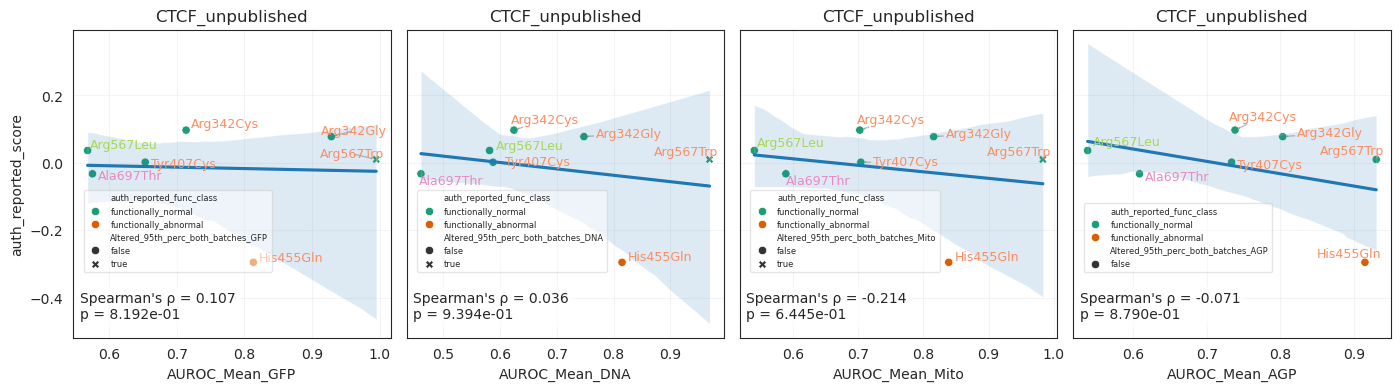

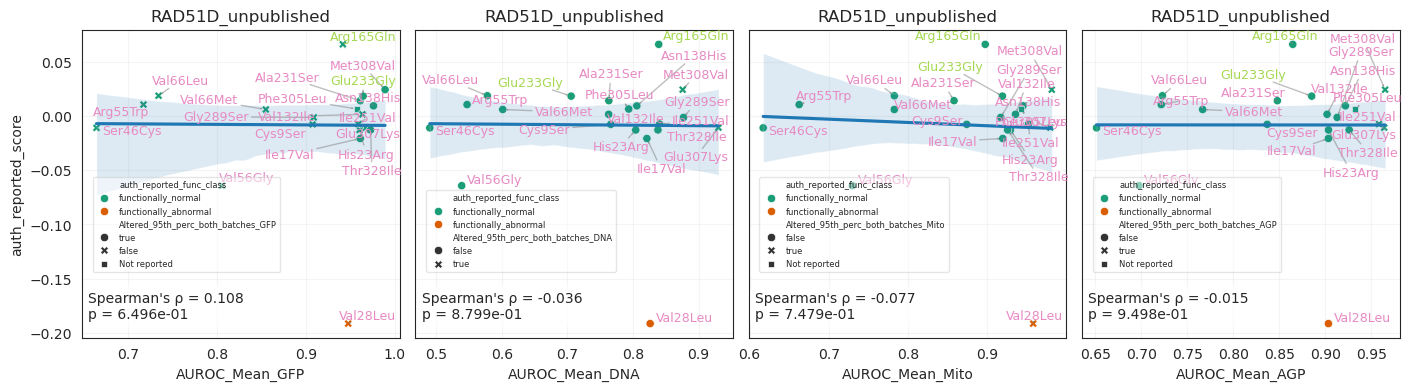

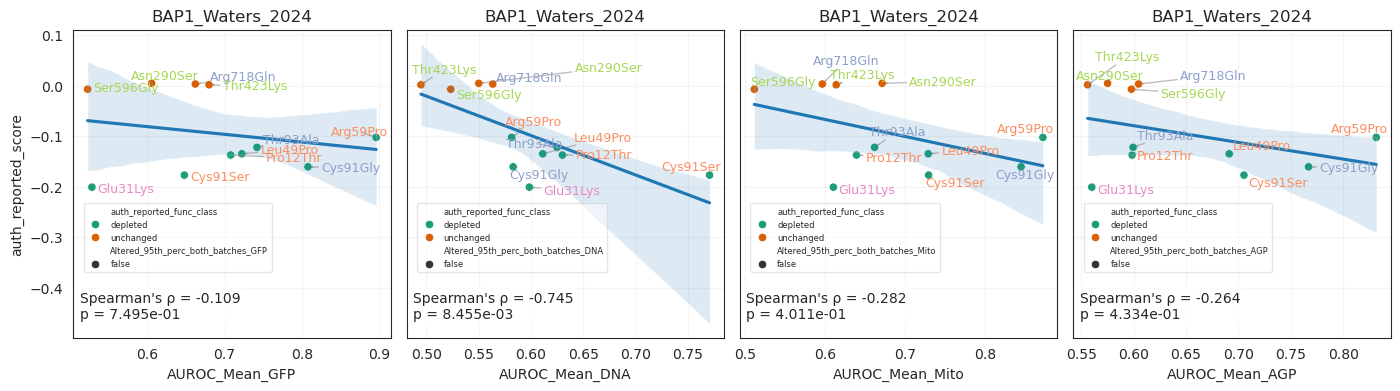

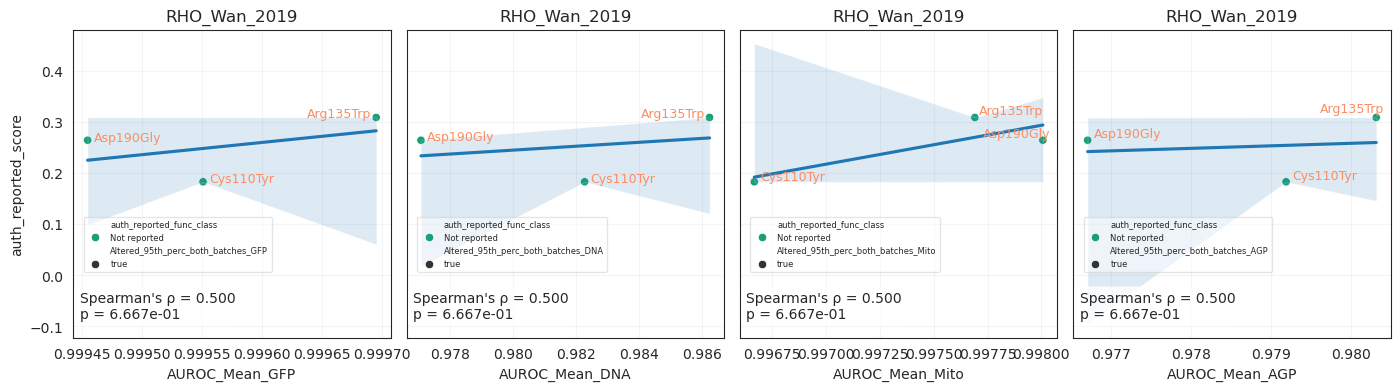

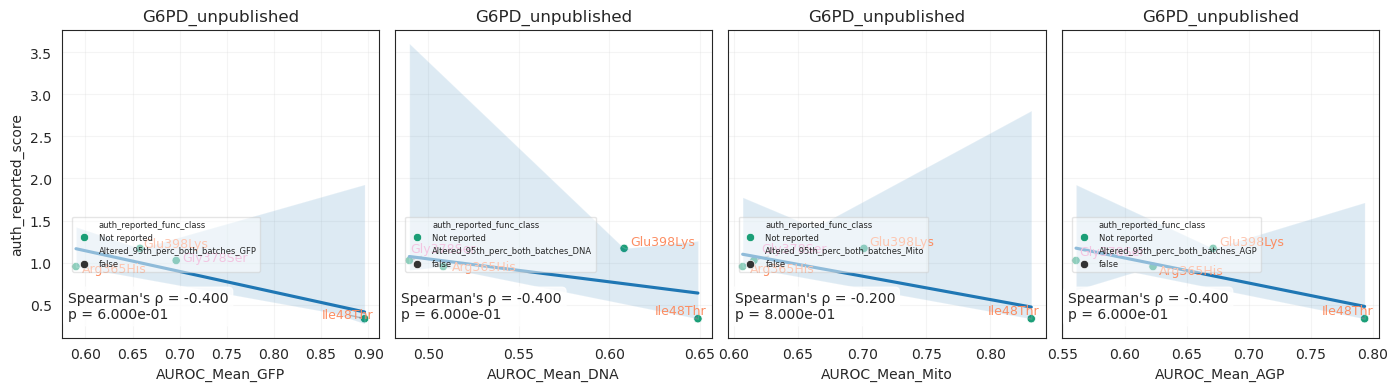

In [634]:
from scipy.stats import spearmanr
from adjustText import adjust_text

for gene in ["CTCF","RAD51D","BAP1","RHO","G6PD"]: ##,"BRCA1",
    imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df.filter(
        pl.col("Gene")==gene
    )
    studies_on_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list()
    unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique().to_list()
    fig, axes = plt.subplots(1, 4, figsize=(17, 4), sharey=True) ##, 
    for j, study in enumerate(studies_on_gene):
       imaging_summary_clinvar_pillar_snp_match_df_gene_study = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
           pl.col("Dataset")==study
       )
       # .select([
       #     col for col in imaging_summary_clinvar_pillar_snp_match_df_gene_study.columns 
       #     if imaging_summary_clinvar_pillar_snp_match_df_gene_study.select(pl.col(col).is_null().all()).item() is False
       # ])
       imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.with_columns(
           pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
       )
       for i, feat in enumerate(FEAT_SETS):
           sns.scatterplot(
               data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.with_columns(
                   pl.col("auth_reported_func_class").fill_null("Not reported").alias("auth_reported_func_class"),
                   pl.col(f"Altered_95th_perc_both_batches_{feat}").fill_null("Not reported").alias(f"Altered_95th_perc_both_batches_{feat}")
               ).to_pandas(),
               y="auth_reported_score",
               x=f"AUROC_Mean_{feat}",
               ax=axes[i],
               hue="auth_reported_func_class",
               style=f"Altered_95th_perc_both_batches_{feat}",
               palette="Dark2"
           )
           sns.regplot(
               data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
               y="auth_reported_score",
               x=f"AUROC_Mean_{feat}",
               ax=axes[i],
               scatter=False
           )
           axes[i].legend(bbox_to_anchor=(0.02,.2), loc="lower left",
                          fontsize=6, framealpha=.5, bbox_transform=axes[i].transAxes)
           # Get pandas dataframe for easier indexing
           plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
           # Add point labels with adjustText
           texts = []
           for idx, row in plot_data.iterrows():
               if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[f"AUROC_Mean_{feat}"])):
                   clinvar_class = row["clinvar_clnsig_clean"]
                   text = axes[i].annotate(
                       row["gene_allele"].split('_')[-1],
                       (row[f"AUROC_Mean_{feat}"], row["auth_reported_score"]),
                       fontsize=9,
                       color=clinvar_color_map[clinvar_class]
                   )
                   texts.append(text)
           adjust_text(texts, ax=axes[i], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
           # Calculate Spearman correlation
           mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[f"AUROC_Mean_{feat}"]))
           rho, p_val = spearmanr(
               plot_data["auth_reported_score"][mask], 
               plot_data[f"AUROC_Mean_{feat}"][mask]
           )
           # Add correlation text to plot
           axes[i].text(
               0.02, 0.15, 
               f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
               transform=axes[i].transAxes,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
           )
           if i == 0:
               axes[i].set_ylabel(f"auth_reported_score")
           else:
               axes[i].set_ylabel("")
           axes[i].set_title(study)
           axes[i].grid(alpha=.2)
    plt.subplots_adjust(wspace=0.05, hspace=0.22)

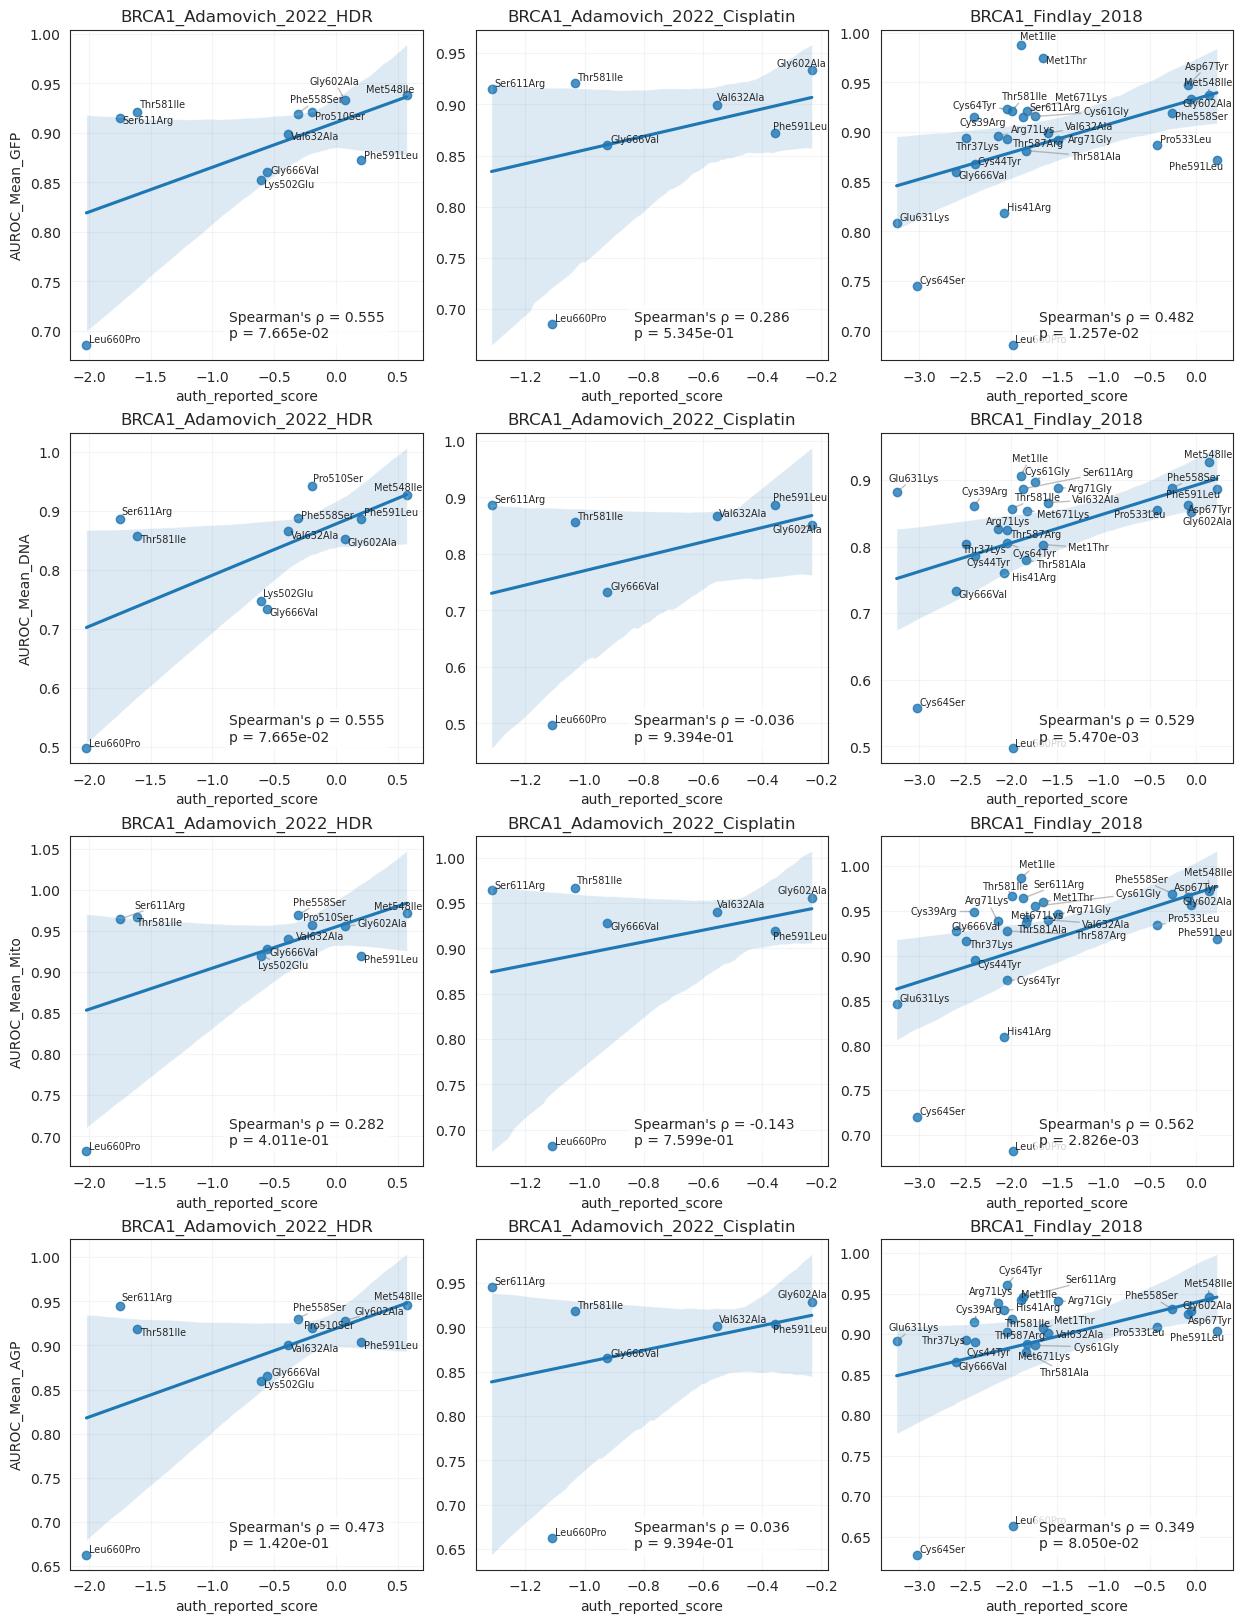

In [369]:
gene = "BRCA1"
imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df.filter(
    pl.col("Gene")==gene
)
studies_on_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list()
unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique().to_list()

fig, axes = plt.subplots(4, len(studies_on_gene), figsize=(15, 20)) ##sharey=True, 
for j, study in enumerate(studies_on_gene):
   imaging_summary_clinvar_pillar_snp_match_df_gene_study = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
       pl.col("Dataset")==study
   )
   imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.select([
       col for col in imaging_summary_clinvar_pillar_snp_match_df_gene_study.columns 
       if imaging_summary_clinvar_pillar_snp_match_df_gene_study.select(pl.col(col).is_null().all()).item() is False
   ]).with_columns(
       pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
   )
   for i, feat in enumerate(FEAT_SETS):
       sns.regplot(
           data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
           x="auth_reported_score",
           y=f"AUROC_Mean_{feat}",
           ax=axes[i, j],
       )
       
       # Get pandas dataframe for easier indexing
       plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
       
       # Add point labels with adjustText
       texts = []
       for idx, row in plot_data.iterrows():
           if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[f"AUROC_Mean_{feat}"])):
               text = axes[i, j].annotate(
                   row["gene_allele"].split('_')[-1],
                   (row["auth_reported_score"], row[f"AUROC_Mean_{feat}"]),
                   fontsize=7
               )
               texts.append(text)
       
       adjust_text(texts, ax=axes[i, j], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
       
       # Calculate Spearman correlation
       mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[f"AUROC_Mean_{feat}"]))
       rho, p_val = spearmanr(
           plot_data["auth_reported_score"][mask], 
           plot_data[f"AUROC_Mean_{feat}"][mask]
       )
       
       # Add correlation text to plot
       axes[i, j].text(
           0.45, 0.15, 
           f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
           transform=axes[i, j].transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
       )
       if j == 0:
           axes[i, j].set_ylabel(f"AUROC_Mean_{feat}")
       else:
           axes[i, j].set_ylabel("")
       axes[i, j].set_title(study)
       axes[i, j].grid(alpha=.2)

plt.subplots_adjust(wspace=0.15, hspace=0.22)

#### Mismatched gene_variants despite matched nuc loc

__All BRCA1 alleles__

In [135]:
imaging_summary_clinvar.join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner"
).filter(
    pl.col("Gene")=="BRCA1"
).with_columns(
    pl.when(pl.col("gene_allele")!=pl.col("gene_variant_pp"))
    .then(False)
    .otherwise(True)
    .alias("Pillar_VarChAMP_Match")
).unique("gene_allele").write_csv("../../3_outputs/brca1_alleles.csv")

In [55]:
# imaging_summary_clinvar.join(
#     pillar_clinvar_df,
#     left_on="gene_allele",
#     right_on="gene_variant",
#     suffix="_pp",
#     how="inner"
# ).unique("gene_allele")

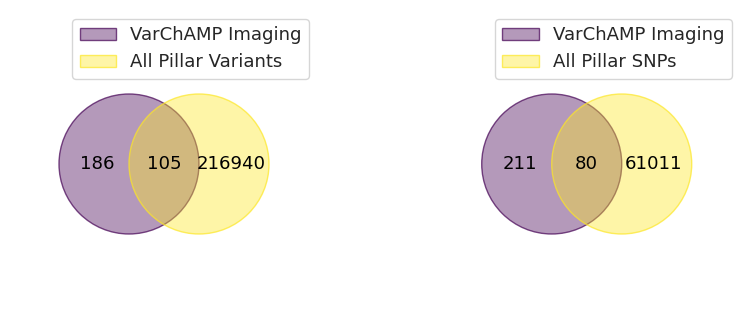

In [31]:
from venn import venn
img_pp_set = {
    'VarChAMP Imaging': set(imaging_summary_clinvar["gene_allele"].unique()),
    'All Pillar Variants': set(pillar_clinvar_df["gene_variant"].unique())
}
img_pp_snp_set = {
    'VarChAMP Imaging': set(imaging_summary_clinvar["gene_allele"].unique()),
    'All Pillar SNPs': set(pillar_clinvar_single_aa_df["gene_variant"].unique())
}
fig, axes = plt.subplots(1,2,figsize=(10,4))
venn(img_pp_set, ax=axes[0])
venn(img_pp_snp_set, ax=axes[1])
plt.show()

In [32]:
imaging_summary_clinvar_pp = imaging_summary_clinvar.join(
    pillar_clinvar_df.select(["gene_variant"]+[c for c in pillar_clinvar_df.columns if c not in imaging_summary_clinvar.columns]),
    left_on="gene_allele",
    right_on="gene_variant",
    how="inner",
    coalesce=True
)

<Figure size 640x480 with 0 Axes>

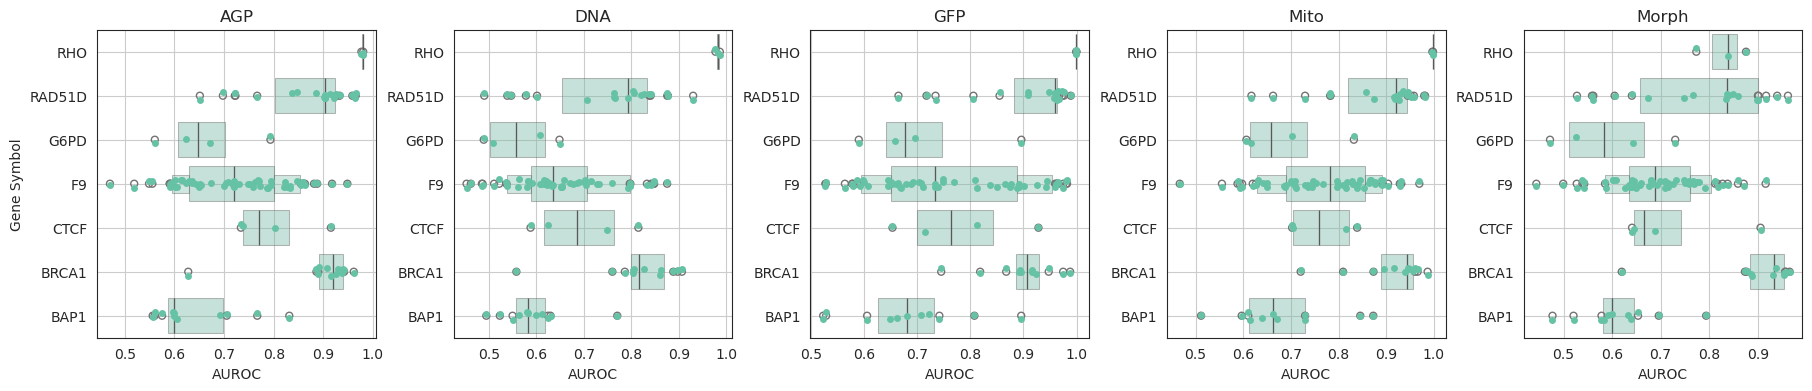

In [33]:
plt.clf()
gene_order_pillar = imaging_summary_clinvar_pp.sort("Gene").unique("Gene")["Gene"]
fig, ax = plt.subplots(1,5,figsize=(22, 4))
for i, col in enumerate(auroc_cols):
    sns.boxenplot(data=imaging_summary_clinvar_pp.unique("gene_variant").to_pandas(),
                  # palette=palette_dict["clinvar_clnsig_clean"], 
                # hue="clinvar_clnsig_clean", 
                # hue_order=hue_order,
                  color=sns.color_palette("Set2")[0],
                  order=gene_order_pillar[::-1],
                  alpha=.4,
                  # gap=.2,
                x=col, y="Gene", ax=ax[i]) #, width=.5
    sns.stripplot(data=imaging_summary_clinvar_pp.unique("gene_variant").to_pandas(),
                  # palette=palette_dict["clinvar_clnsig_clean"], 
                # hue="clinvar_clnsig_clean", 
                # hue_order=hue_order,
                  color=sns.color_palette("Set2")[0],
                  order=gene_order_pillar[::-1],
                  # gap=.2,
                x=col, y="Gene", ax=ax[i]) #, width=.5
    
    ax[i].set_xlabel("AUROC")
    ax[i].set_ylabel("")
    ax[i].set_title(col.split("_")[-1])
    ax[i].grid()
ax[0].set_ylabel("Gene Symbol")
plt.subplots_adjust(wspace=.28)
plt.show()

<Figure size 640x480 with 0 Axes>

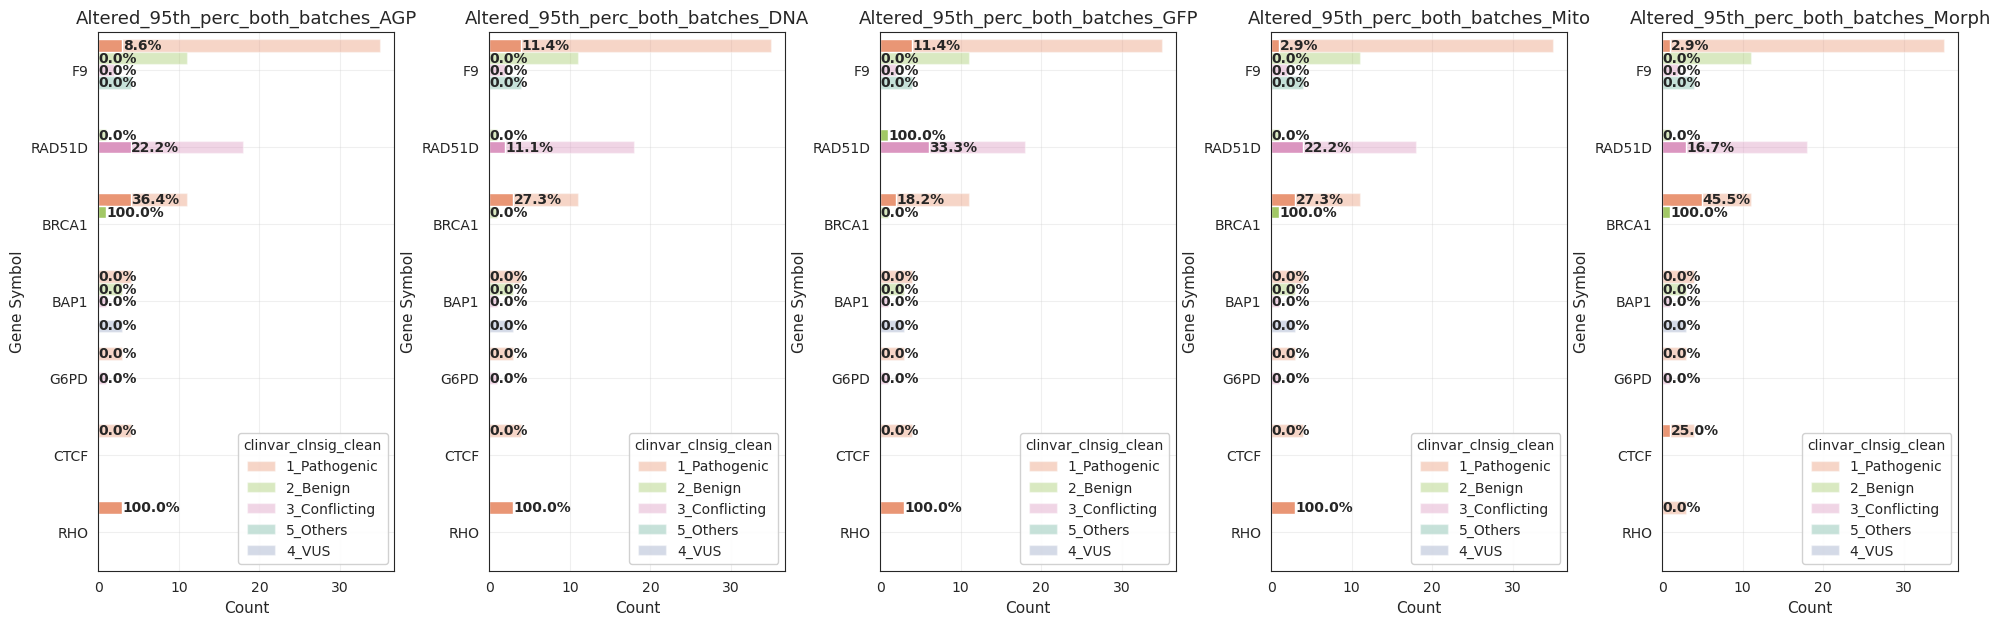

In [34]:
# plt.clf()
# fig, ax = plt.subplots(1,5,figsize=(20, 4))
# for i, col in enumerate(alter_95th_cols):
#     plot_gene_level_summary(scores.with_columns(
#         pl.col(col).cast(pl.Boolean).alias(col)
#     ), col, col+"\n", gene_order=gene_order_pillar, hits_only=False, ax=ax[i])

# # fig, ax = plt.subplots(1,1,figsize=(6,15))
# # plot_gene_level_summary(scores, "Altered_95th_perc_Morph", "Altered_95th_perc_Morph", hits_only=False, null_only=True, ax=ax)

# # fig, ax = plt.subplots(1,1,figsize=(6,4))
# # plot_gene_level_summary(func_scores, "dualipa_abund_change", "DUAL-IPA Abundance Change Pillar Variants", hits_only=False, ax=ax)
# plt.subplots_adjust(wspace=.32)
# plt.show()

plt.clf()
fig, ax = plt.subplots(1,5,figsize=(24, 7))
for i, col in enumerate(alter_95th_cols):
    plot_gene_level_summary(imaging_summary_clinvar_pp.unique("gene_variant").with_columns(
        pl.col(col).cast(pl.Boolean).alias(col)
    ), assay=col, ax=ax[i], palette=palette_dict["clinvar_clnsig_clean"]) ## gene_order=gene_order, hits_only=False,, col, col+"\n"
    ax[i].grid(alpha=.3)

plt.subplots_adjust(wspace=.32)
plt.show()

In [637]:
# import polars as pl
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
# import requests
# import glob
# import gzip
# import re
# import os
# import py3Dmol
# from Bio.PDB import PDBParser
# import requests
# import gzip

# def get_uniprot_swissprot_id(protein_name: str) -> str:
#     """
#     Query UniProt’s REST search API to find the reviewed (Swiss‐Prot) accession
#     for a given human gene/protein name. Returns None if not found.
#     """
#     url = "https://rest.uniprot.org/uniprotkb/search"
#     # Build a query that:
#     #  - matches the gene name exactly (using “gene:”)
#     #  - restricts to human (organism_id:9606)
#     #  - restricts to reviewed (Swiss‐Prot) entries
#     query = f"gene:{protein_name} AND organism_id:9606 AND reviewed:true"
#     params = {
#         "query": query,
#         "fields": "accession",
#         "format": "json",
#         "size": 1,      # only need the top hit
#     }
#     try:
#         resp = requests.get(url, params=params, timeout=10)
#         resp.raise_for_status()
#         data = resp.json()
#         results = data.get("results", [])
#         if not results:
#             return None
#         return results[0]["primaryAccession"]
#     except Exception:
#         # If the request fails (e.g. no internet), return None
#         return None

# gene = "RAD51D"
# gene_uniprot_id = get_uniprot_swissprot_id(gene)
# print(f"UniProt Swiss‐Prot ID for {gene}:", {gene_uniprot_id} or "Not found")

# af2_struc_pdb_dir = "/data/shenrunx/igvf/varchamp/2025_laval_submitted/compare_ai_scores/1_inputs/new_raw_data/alphafold/UP000005640_9606_HUMAN_v4"

# pdb_file = [pdb for pdb in glob.glob(f"{af2_struc_pdb_dir}/*.pdb.gz") if gene_uniprot_id in pdb][0]
# pdb_file

# # 1. Parse the structure
# # 1) Open the .pdb.gz file with gzip.open in text/binary mode:
# with gzip.open(pdb_file, "rt") as handle:
#     parser = PDBParser(QUIET=True)
#     structure = parser.get_structure("rho", handle)

#     # 3. Rewind and read the entire PDB text
#     handle.seek(0)
#     pdb_text = handle.read()

# # 2. Build a map: residue_number → (x, y, z) of its Cα atom
# ca_coords = {}
# for model in structure:
#     for chain in model:
#         if chain.get_id() == "A":
#             for residue in chain:
#                 resnum = residue.get_id()[1]
#                 # Only consider standard amino acids with a CA atom
#                 if 'CA' in residue:
#                     atom_ca = residue['CA']
#                     ca_coords[resnum] = atom_ca.get_coord()

# # 2) List of variants in “RHO_AminoAcidResidueNumberNewAminoAcid” format.
# #    We assume that the PDB’s residue numbering matches exactly the numbers in these strings.
# variants_raw = rad51d_allele.filter(pl.col("gene_allele").str.contains(f"{gene}_"))["gene_allele"].unique()
# # 3) The chain ID in the PDB that contains Rhodopsin.
# #    If your PDB uses a different chain (e.g. “B”), adjust accordingly.
# chain_id = "A"
# # 4) If your PDB has insertion codes (e.g. 106A, 106B), you must handle that.
# #    In this example, we assume no insertion codes (icode = " ").
# default_icode = " "
# # Confirm chain exists
# model = structure[0]  # first (and usually only) model
# if chain_id not in model:
#     raise ValueError(f"Chain '{chain_id}' not found in {pdb_file}.")
# # ---- STEP 2: Convert each raw‐string into (chain, resi, icode, label) ----
# variant_list = []
# pattern = re.compile(rf"{gene}_([A-Za-z]{{3}})(\d+)([A-Za-z]{{3}})")
# for raw in variants_raw:
#     m = pattern.match(raw)
#     if not m:
#         print(f"Warning: '{raw}' does not match expected pattern 'RHO_Aaa###Bbb'. Skipping.")
#         continue
#     wt_3letter, resi_str, mut_3letter = m.groups()
#     resi = int(resi_str)
#     # Convert three‐letter codes to one‐letter for a concise label if you like.
#     # Here, we'll keep the original string as the label.
#     label = raw
#     variant_list.append({
#         "chain": chain_id,
#         "resi": resi,
#         "icode": default_icode,
#         "label": label
#     })

# print(variant_list)
# if not variant_list:
#     raise RuntimeError("No valid variants found. Please check your variant strings.")

In [636]:
# # Define 3D offsets for each residue
# offsets_3d = {
#     135: {'x': +1.0, 'y': +0.5, 'z': +0.5},
#     110: {'x': -1.0, 'y': +0.5, 'z': +0.5},
#     190: {'x':  0.0, 'y': -1.0, 'z': +0.5}
# }

# view = py3Dmol.view(width=800, height=600)
# view.addModel(pdb_text, 'pdb')
# view.setStyle({'cartoon': {'color': 'spectrum'}})

# residues_to_label = [var['resi'] for var in variant_list]

# # Define colors for each residue
# residue_colors = {
#     135: 'red',
#     110: 'blue', 
#     190: 'green'
# }

# # Style and label each residue individually with different colors
# for resi in residues_to_label:
#     color = "red" if rad51d_allele.filter(
#         pl.col("gene_allele").str.contains(str(resi))
#     )["Altered_95th_perc_both_batches_GFP"].to_numpy()[0] else "green"
    
#     # Set sphere style for this residue
#     view.setStyle({'chain': 'A', 'resi': resi}, {'sphere': {'color': color, 'radius': .5}})
    
#     # Add label for this residue
#     view.addResLabels(
#         {'chain': 'A', 'resi': resi},
#         {'fontColor': color, 'fontSize': 15, 'showBg': False}
#     )

# view.zoomTo()
# view.show()
    
# view.zoomTo()
# view.show()